In [1]:
# Libraries used
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


import folium
from folium.plugins import FastMarkerCluster
from branca.colormap import LinearColormap

In [2]:
# import data
# original inside airbnb
listings=pd.read_csv('columbus_listings.csv')
calendar = pd.read_csv('calendar.csv.gz', compression='gzip')

In [3]:
listings.drop_duplicates(keep=False,inplace=True)
calendar.drop_duplicates(keep=False,inplace=True)

## Replace null value by 0 
listings ['reviews_per_month']. fillna(0,inplace=True)
listings ['last_review']. fillna(0,inplace=True)


In [4]:
# Convert latitude and longitude to zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode

def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

lat = listings['latitude']
lon = listings['longitude']
zp = pd.DataFrame({'lat':lat, 'lon':lon})

zp['zipcode'] = zp.apply(lambda x: get_zipcode(x.lat,x.lon), axis=1)
zp

lat       lon zipcode
0     39.98394 -83.00321   43201
1     40.01243 -83.00986   43210
2     39.96086 -82.97968   43203
3     40.01259 -83.00164   43210
4     40.01259 -83.00164   43210
...        ...       ...     ...
1346  39.98636 -83.00442   43201
1347  40.02073 -83.00327   43202
1348  39.99151 -83.05214   43212
1349  40.10867 -83.06072   43235
1350  39.96183 -83.02712   43215

[1351 rows x 3 columns]

In [5]:
listings=listings.merge(zp,how="left", left_on=['latitude','longitude'], right_on=['lat','lon'])
listings.drop(columns=['lat','lon'],inplace=True)
listings.head()

#listings.to_csv('listings_zipcode.csv')

id                                              name  host_id  \
0   90676                  Short North - Italianate Cottage   483306   
1  543140                Private queen bedroom 1 - N.Campus  2350409   
2  591101   The Bellows' Studio Loft  (3rd floor apartment)  2889677   
3  923248  1 Single Bed in a Shared Coed Dorm at the Hostel  4965048   
4  923248  1 Single Bed in a Shared Coed Dorm at the Hostel  4965048   

       host_name  neighbourhood_group          neighbourhood  latitude  \
0  Audra & Lacey                  NaN  Near North/University  39.98394   
1         Edward                  NaN  Near North/University  40.01243   
2           Gail                  NaN              Near East  39.96086   
3         Mathew                  NaN  Near North/University  40.01259   
4         Mathew                  NaN  Near North/University  40.01259   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0  -83.00321  Entire home/apt    135               1                496   
1  -83.00986     Private room     26               3                107   
2  -82.97968     Private room     80               2                242   
3  -83.00164      Shared room     35               1                241   
4  -83.00164      Shared room     35               1                241   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2021-09-21              30.24                               3   
1  2021-09-05               1.63                               3   
2  2021-09-11               5.84                               1   
3  2021-09-12               3.72                               7   
4  2021-09-12               3.72                               7   

   availability_365  number_of_reviews_ltm    license zipcode  
0               180                    101  2019-1568   43201  
1               333                      9  2019-1344   43210  
2               352                     20  2019-1230   43203  
3               365                     20  2019-1314   43210  
4               365                     20  2019-1314   43210

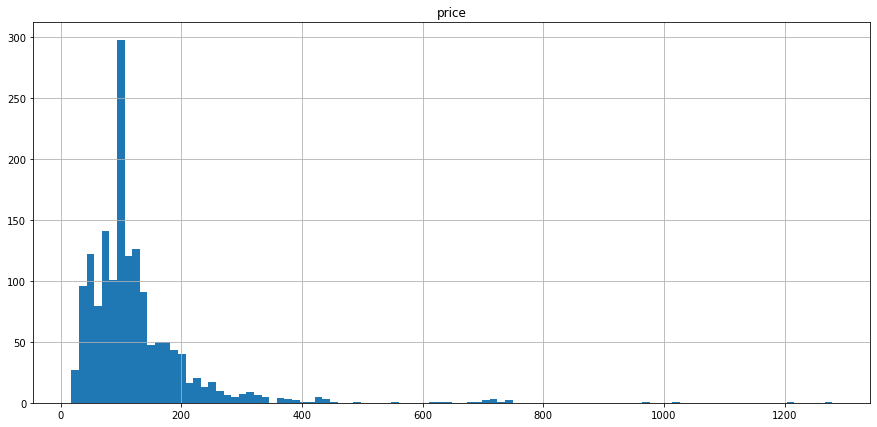

In [6]:
listings.hist(column = "price", bins = 100, figsize = (15, 7),fill=True)
plt.show()

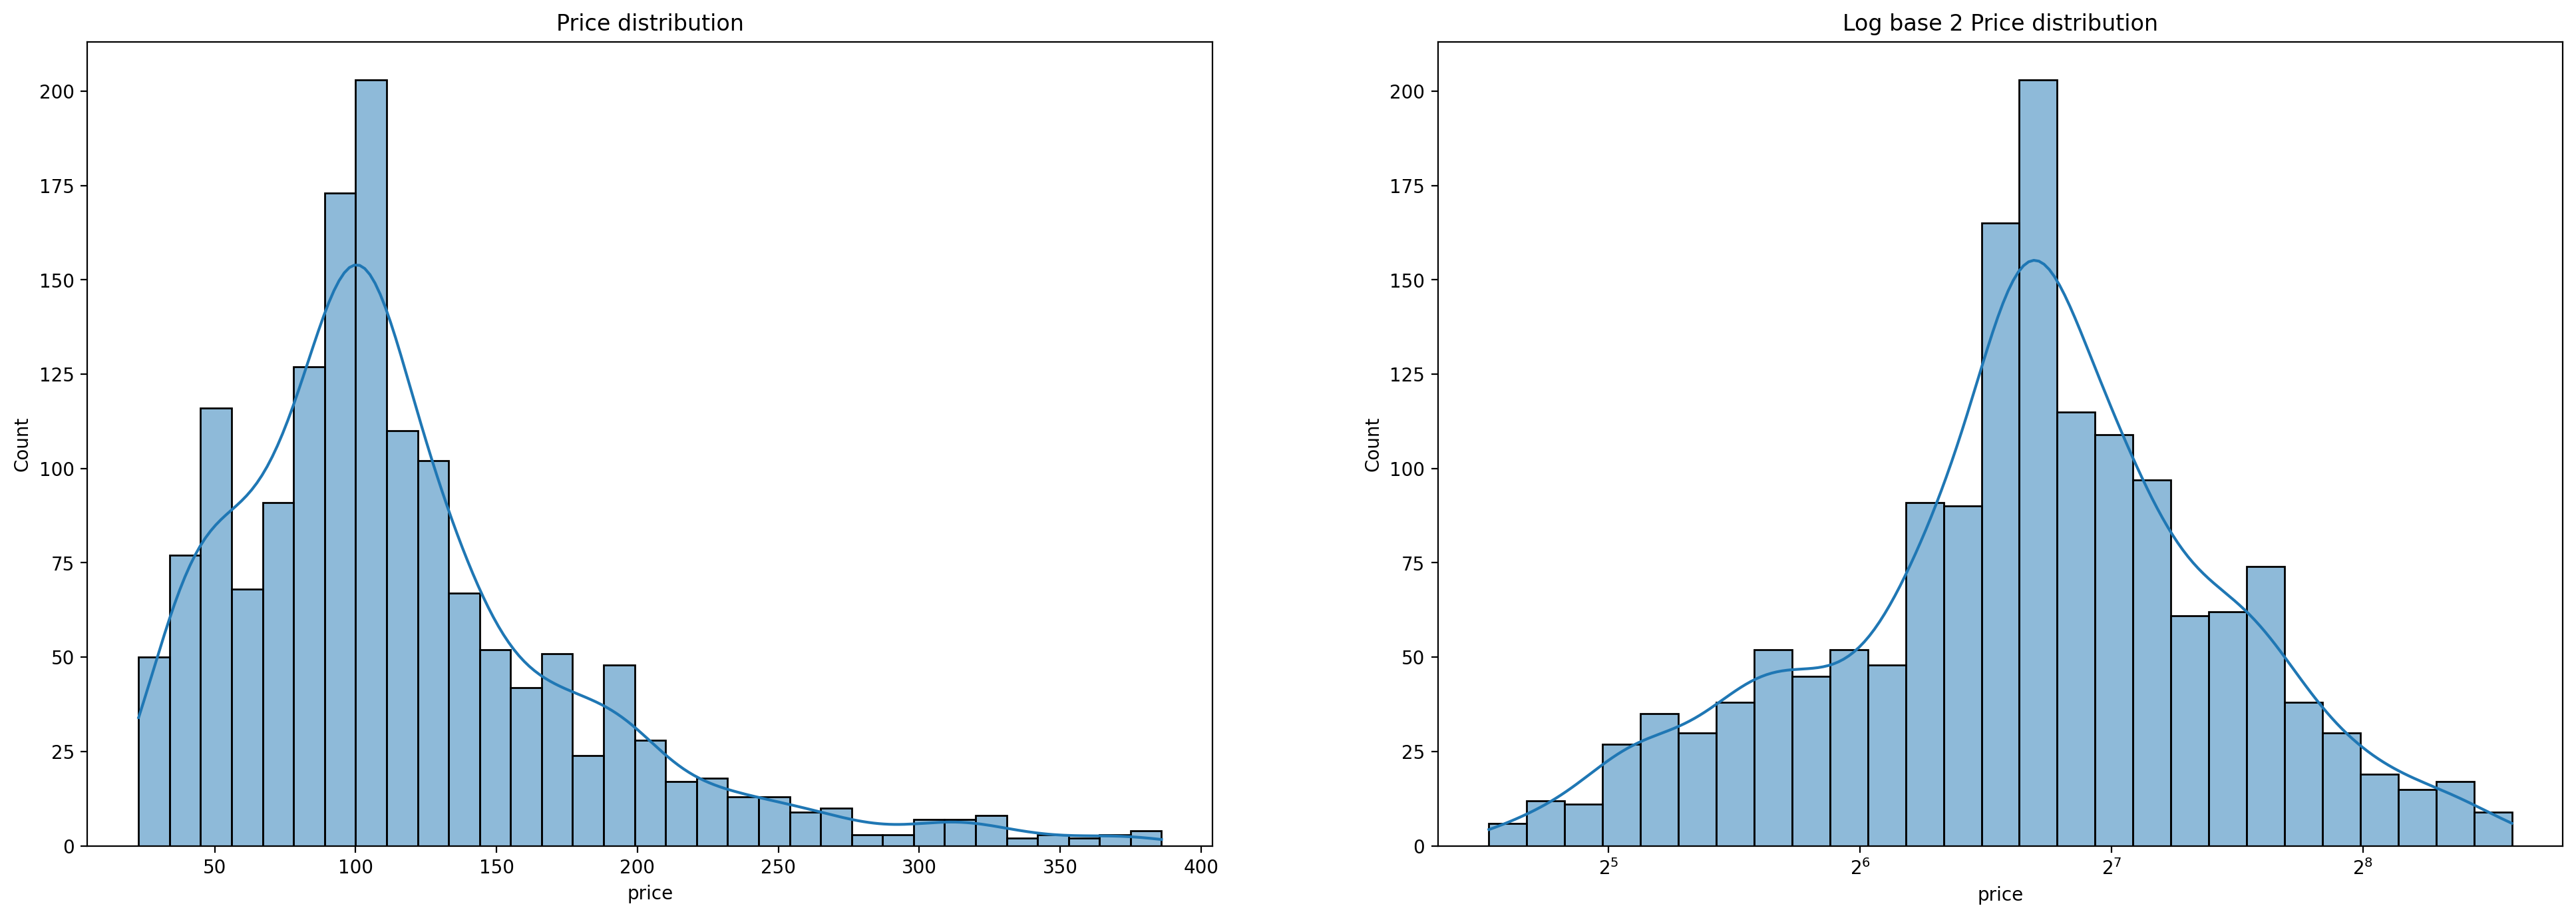

count    1551.000000
mean      115.665377
std        62.272934
min        23.000000
25%        75.500000
50%       103.000000
75%       140.000000
max       386.000000
Name: price, dtype: float64


In [7]:
# remove outliers，and plot the price distribution
listings_nooutlier = listings[(listings['price'] > 20) & (listings['price'] < 400)]

fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=200)
axs[0].set_title('Price distribution')
axs[1].set_title('Log base 2 Price distribution')
sns.histplot(listings_nooutlier['price'], kde=True, ax=axs[0])
sns.histplot(listings_nooutlier['price'].astype(int), kde=True, log_scale=2, ax=axs[1])
plt.show()

print(listings_nooutlier['price'].describe())

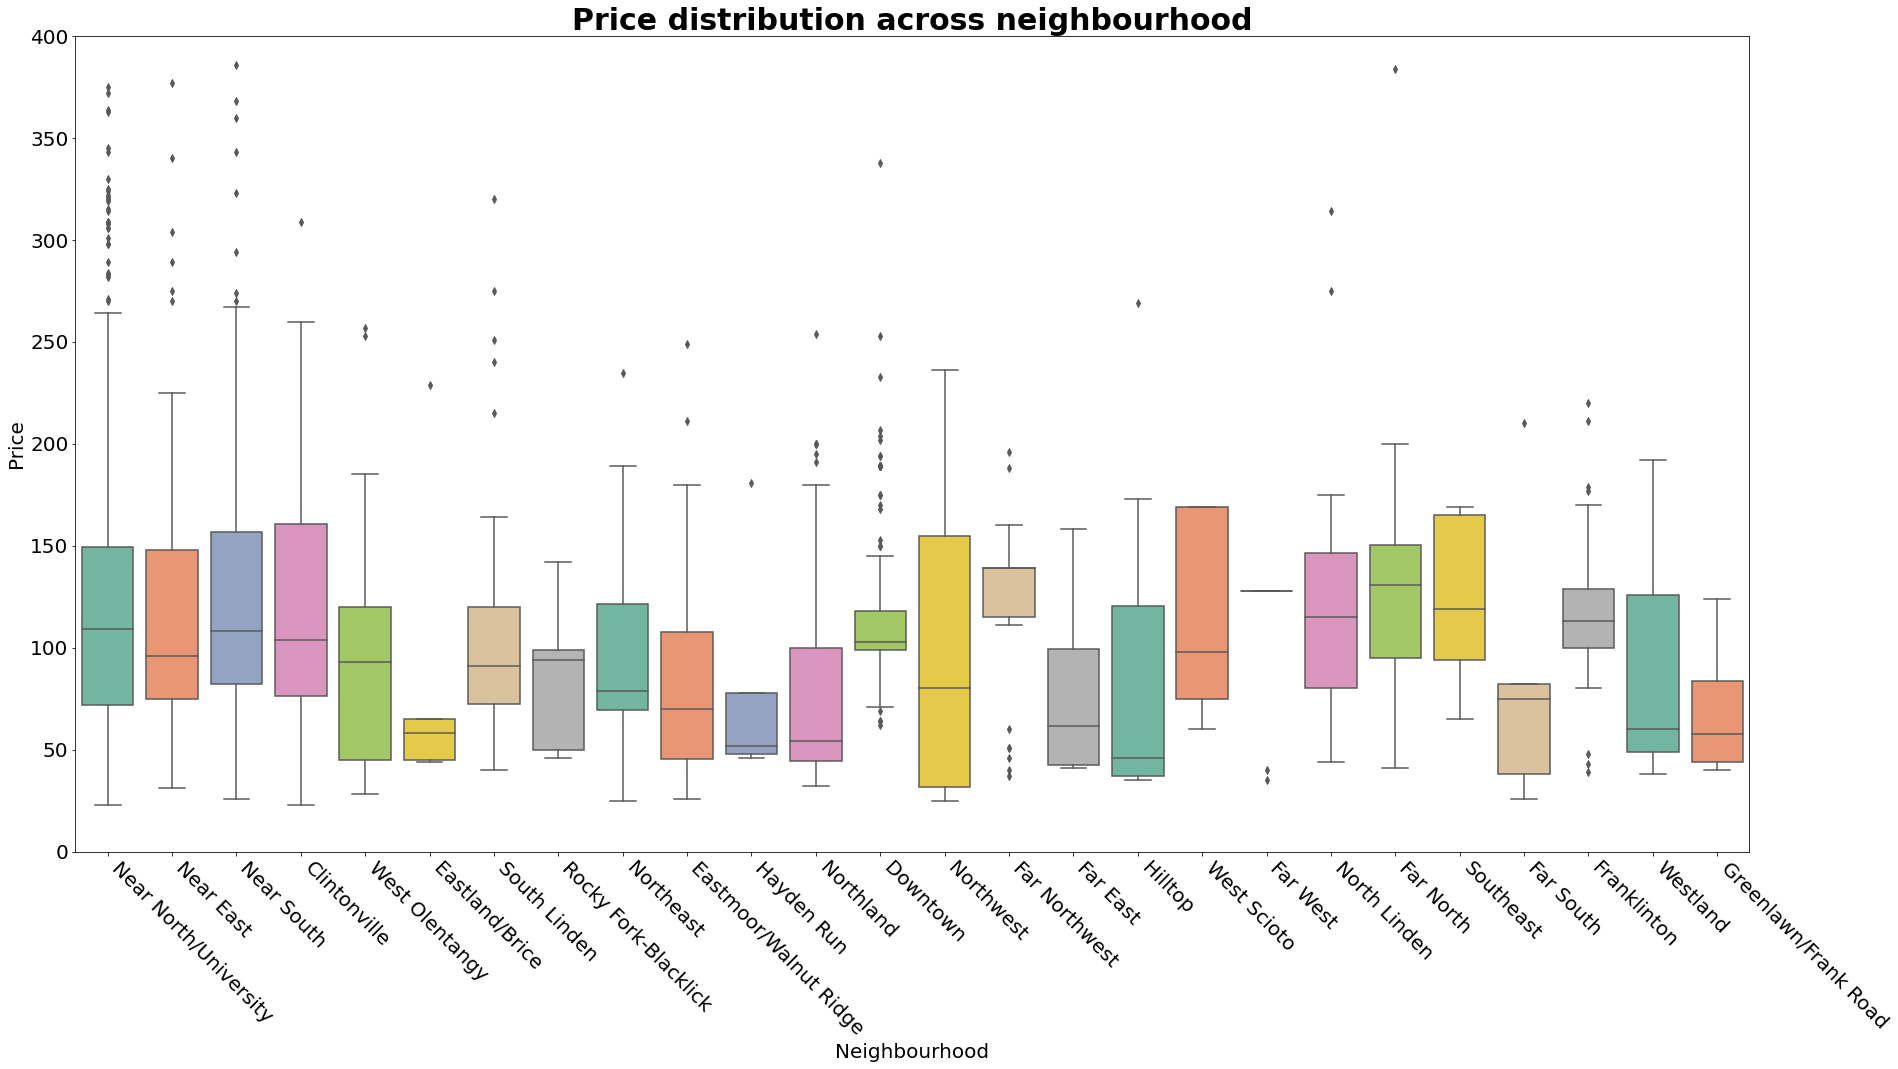

In [8]:
# Check the price distribution per neighborhood 
plt.figure(figsize=(30,15))
plt.title("Price distribution across neighbourhood",size=30,fontweight='bold')

sns.boxplot(data=listings_nooutlier, x='neighbourhood', y='price',palette="Set2")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
plt.tick_params(labelsize=20)
plt.ylabel('Price',fontdict={'size' :20})
plt.xlabel('Neighbourhood',fontdict={'size' :20})
plt.ylim([0,400])
plt.show()

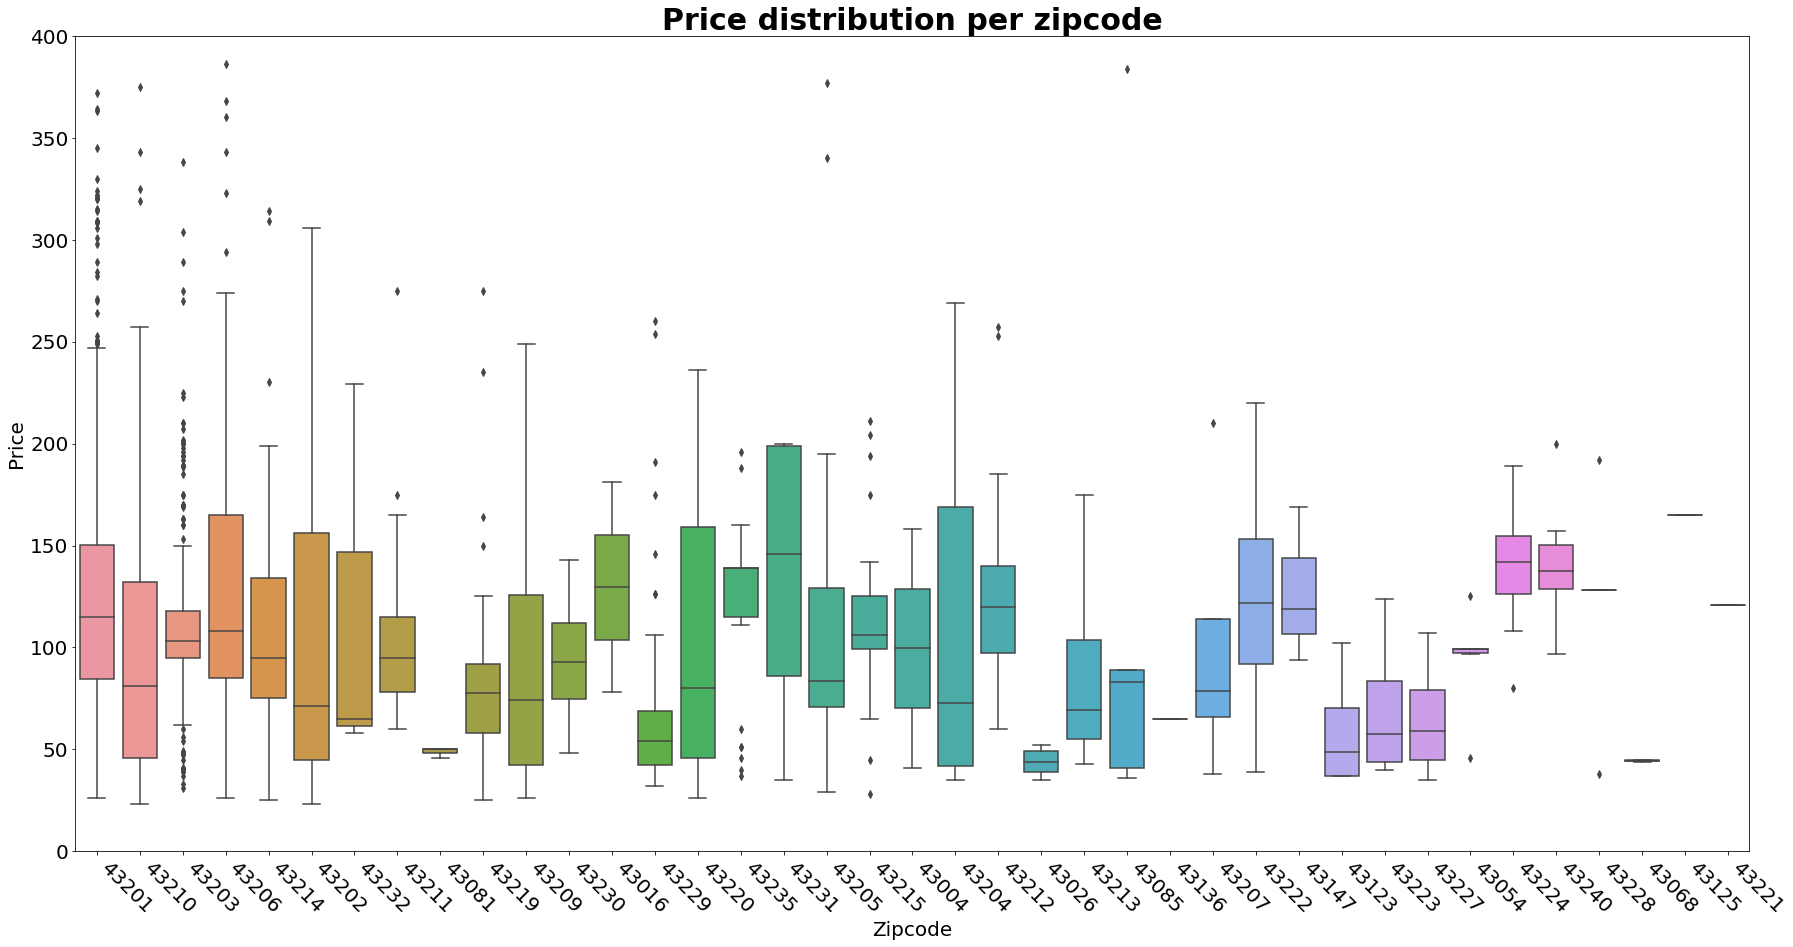

In [9]:
# Check the price distribution per zipcode 
plt.figure(figsize=(30,15))
plt.title("Price distribution per zipcode",size=30,fontweight='bold')

sns.boxplot(data=listings_nooutlier, x='zipcode', y='price')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
plt.tick_params(labelsize=20)
plt.ylabel('Price',fontdict={'size' :20})
plt.xlabel('Zipcode',fontdict={'size' :20})
plt.ylim([0,400])
plt.show()

In [10]:
import geopandas as gpd
columbus  = gpd.read_file('columbus_neighbourhoods.geojson')
columbus.head()

neighbourhood neighbourhood_group  \
0              Near East                None   
1  Near North/University                None   
2               Downtown                None   
3         West Olentangy                None   
4               Westland                None   

                                            geometry  
0  MULTIPOLYGON (((-82.94216 39.97987, -82.94319 ...  
1  MULTIPOLYGON (((-82.99677 40.01955, -82.99663 ...  
2  MULTIPOLYGON (((-82.98395 39.97937, -82.98324 ...  
3  MULTIPOLYGON (((-83.10412 40.06146, -83.10295 ...  
4  MULTIPOLYGON (((-83.11921 39.97636, -83.11931 ...

In [11]:
avg_p = listings_nooutlier.groupby(['neighbourhood','zipcode'],as_index=False)['price'].mean()
avg_p1 = avg_p.round(2)
avg_p1.sort_values(by='price',axis=0,ascending=False,inplace=True)
avg_p2 = pd.DataFrame(avg_p1)
avg_p2.head()

neighbourhood zipcode   price
43  North Linden   43219  275.00
42  North Linden   43214  193.33
2   Clintonville   43229  193.00
3       Downtown   43201  176.00
60     Southeast   43125  165.00

In [12]:
# Merge columbus and avg_p2 tables 
columbus_avprice = columbus.merge(avg_p2,how="left", left_on="neighbourhood", right_on="neighbourhood")
columbus_avprice.head()

neighbourhood neighbourhood_group  \
0              Near East                None   
1              Near East                None   
2  Near North/University                None   
3  Near North/University                None   
4  Near North/University                None   

                                            geometry zipcode   price  
0  MULTIPOLYGON (((-82.94216 39.97987, -82.94319 ...   43203  121.16  
1  MULTIPOLYGON (((-82.94216 39.97987, -82.94319 ...   43205  107.14  
2  MULTIPOLYGON (((-82.99677 40.01955, -82.99663 ...   43202  133.54  
3  MULTIPOLYGON (((-82.99677 40.01955, -82.99663 ...   43201  128.02  
4  MULTIPOLYGON (((-82.99677 40.01955, -82.99663 ...   43215  109.33

In [13]:
import branca
from collections import OrderedDict
cmaps = OrderedDict()

colormap = branca.colormap.LinearColormap(
    vmin=columbus_avprice["price"].quantile(0.0),
    vmax=columbus_avprice["price"].quantile(1),
    colors=["red", "yellow", "lightblue", "green", "darkgreen"],
    caption="Columbus Average Airbnb Price level",
)


In [14]:
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip

m = folium.Map(location=[39.9611755, -82.9987942], default_zoom_start=12)

popup = GeoJsonPopup(
    fields=["neighbourhood","zipcode", "price"],
    aliases=["Neighbourhood","Zipcode", "Average Airbnb Price:"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)

tooltip = GeoJsonTooltip(
    fields=["neighbourhood","zipcode","price"],
    aliases=["Neighbourhood:","Zipcode","Average Airbnb Price:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

g = folium.GeoJson(
    columbus_avprice,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["price"])
        if x["properties"]["price"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip=tooltip,
    popup=popup,
).add_to(m)
colormap.add_to(m)

m

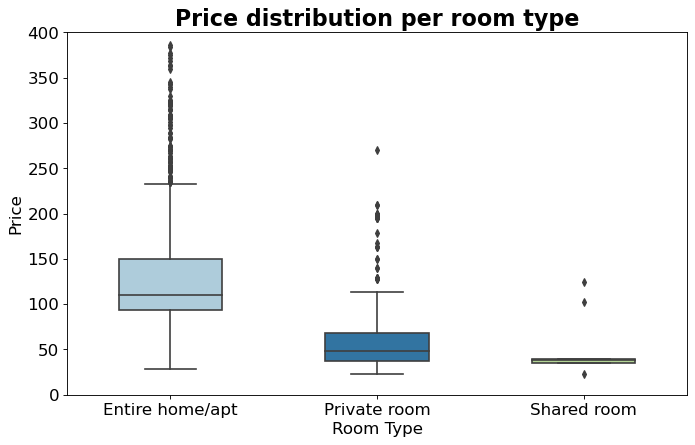

In [15]:
# Check the price distribution per room type
plt.figure(figsize=(10,6),dpi=80)
plt.title("Price distribution per room type",size=20,fontweight='bold')

sns.boxplot(data=listings_nooutlier, x='room_type', y='price',palette="Paired",width=.5)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), ha='center')
plt.tick_params(labelsize=15)
plt.ylabel('Price',fontdict={'size' :15})
plt.xlabel('Room Type',fontdict={'size' :15})
plt.ylim([0,400])
plt.show()

In [16]:
# Average price per room type across neighborhood 
avg_price = listings_nooutlier.groupby(['neighbourhood','room_type'],as_index=False)['price'].mean()
avg_price1 = avg_price.round(2)
avg_price2 = avg_price1.sort_values(by='price',axis=0,ascending=False)
avg_price3 = pd.DataFrame(avg_price2)
avg_price3.head()

neighbourhood        room_type   price
3   Eastland/Brice  Entire home/apt  229.00
23      Hayden Run  Entire home/apt  181.00
25         Hilltop  Entire home/apt  153.83
10       Far North  Entire home/apt  153.45
36    North Linden  Entire home/apt  142.93

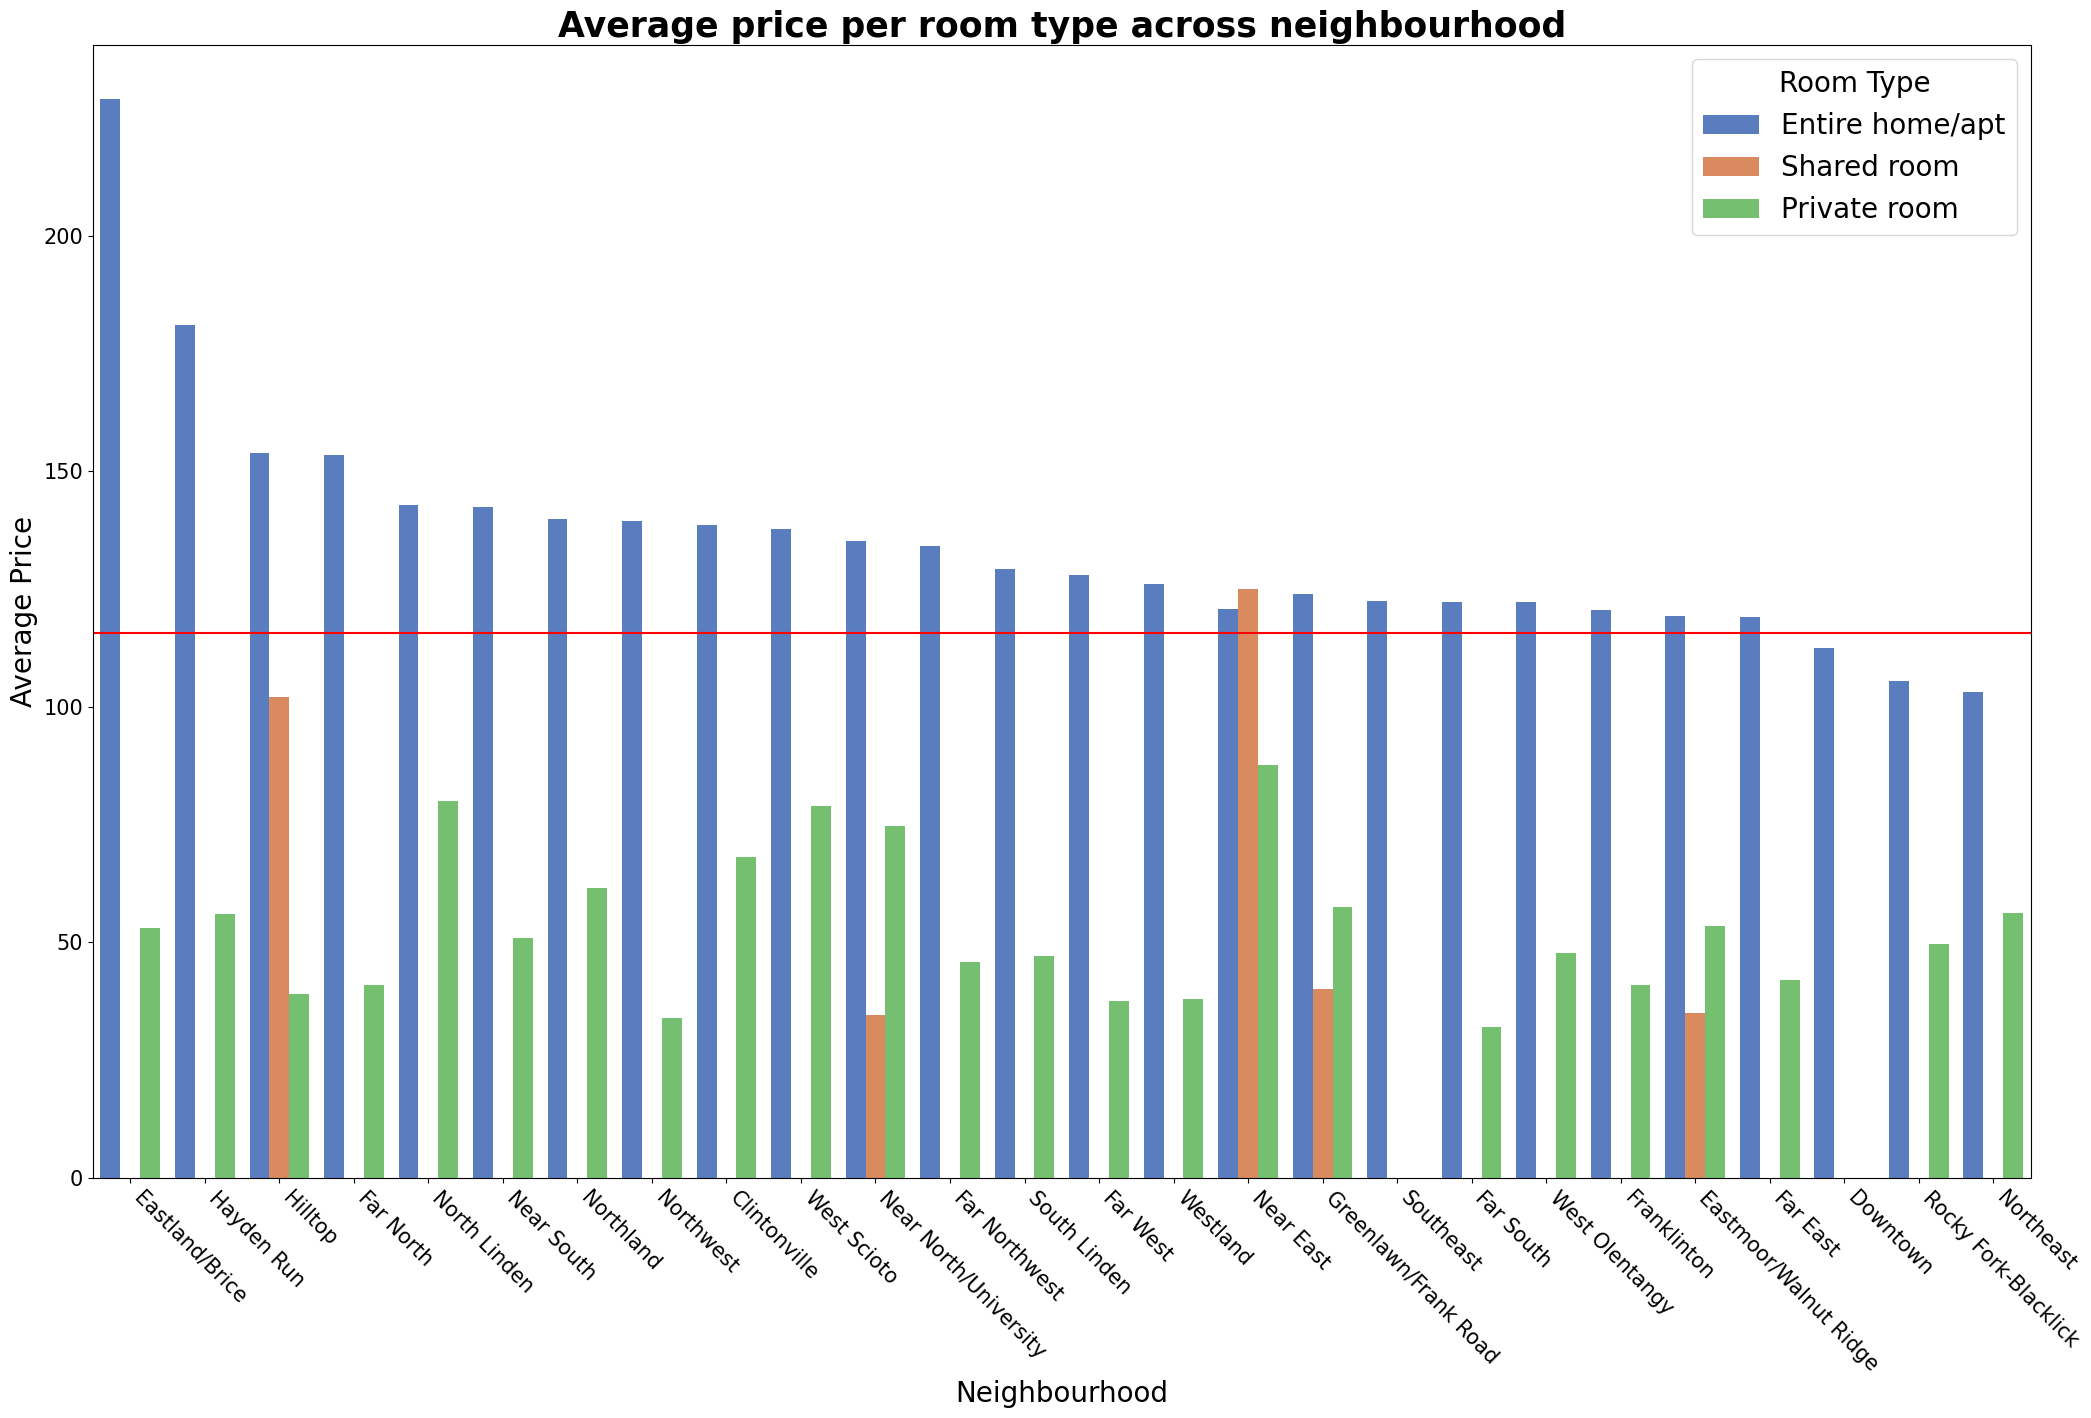

In [17]:
plt.figure(figsize=(25,15),dpi=100)
plt.title("Average price per room type across neighbourhood",size=25,fontweight='bold')

sns.barplot(x='neighbourhood',y='price',hue='room_type',data=avg_price3, palette="muted")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
plt.tick_params(labelsize=15)
plt.ylabel('Average Price',fontdict={'size' :20})
plt.xlabel('Neighbourhood',fontdict={'size' :20})
plt.legend(title='Room Type',loc='upper right',fontsize=20,title_fontsize=20)
plt.axhline(y=115.67, color='r', linestyle='-')
plt.show()

In [18]:
# Average price per room type per zipcode 
avg_zprice = listings_nooutlier.groupby(['zipcode','room_type'],as_index=False)['price'].mean()
avg_zprice1 = avg_zprice.round(2)
avg_zprice2 = avg_zprice1.sort_values(by='price',axis=0,ascending=False)
avg_zprice3 = pd.DataFrame(avg_zprice2)
avg_zprice3.head()

zipcode        room_type   price
69   43232  Entire home/apt  229.00
9    43085  Entire home/apt  185.33
2    43016  Entire home/apt  181.00
14   43125  Entire home/apt  165.00
0    43004  Entire home/apt  158.00

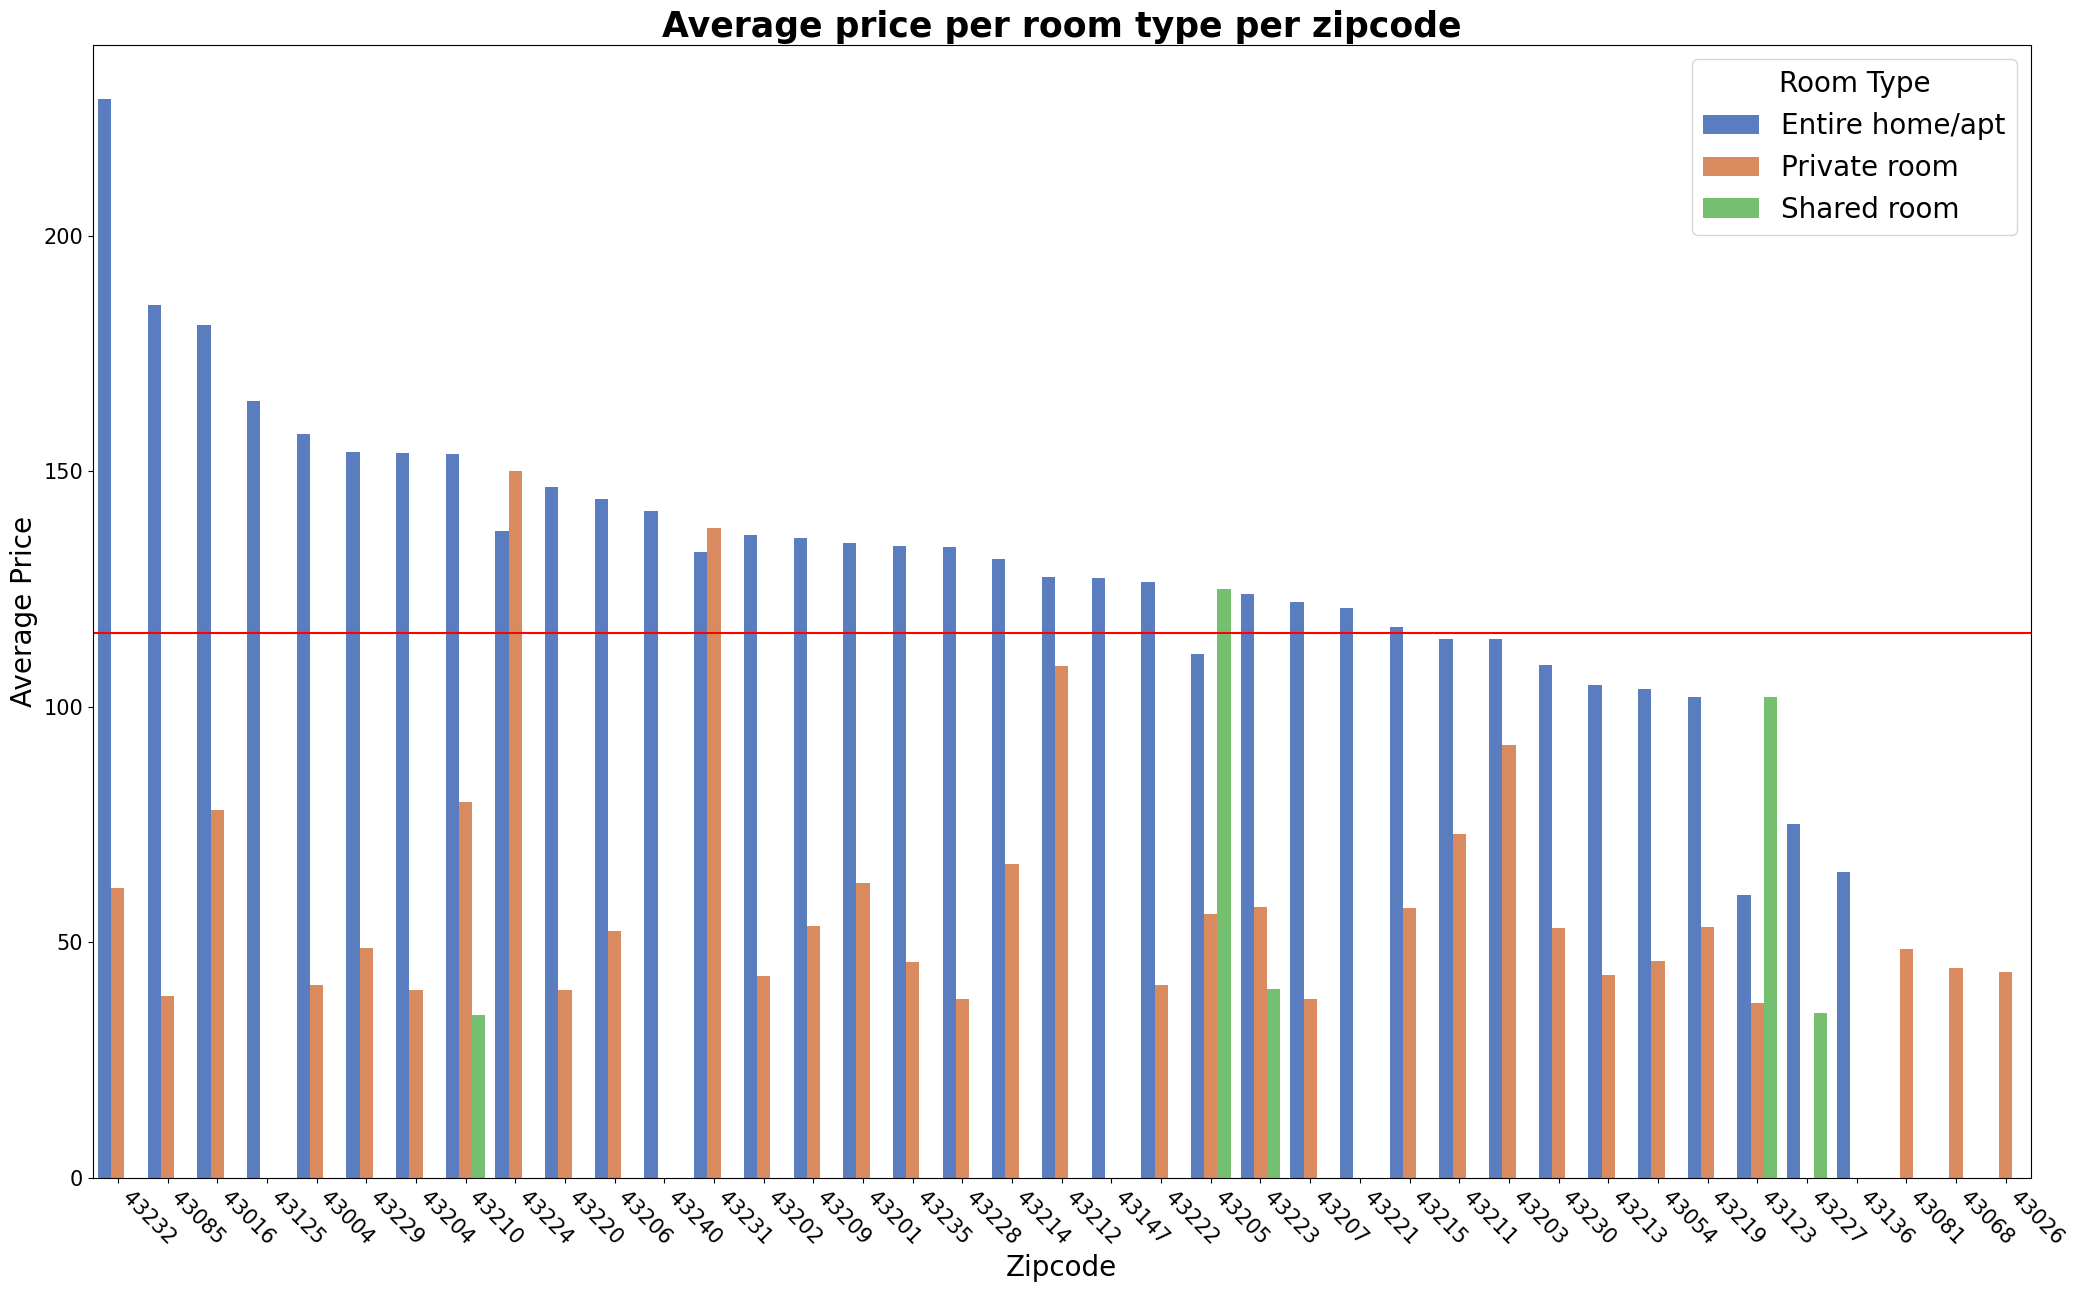

In [19]:
plt.figure(figsize=(25,15),dpi=100)
plt.title("Average price per room type per zipcode",size=25,fontweight='bold')

sns.barplot(x='zipcode',y='price',hue='room_type',data=avg_zprice3, palette="muted")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
plt.tick_params(labelsize=15)
plt.ylabel('Average Price',fontdict={'size' :20})
plt.xlabel('Zipcode',fontdict={'size' :20})
plt.legend(title='Room Type',loc='upper right',fontsize=20,title_fontsize=20)
plt.axhline(y=115.67, color='r', linestyle='-')
plt.show()

In [20]:
# Count numbers per room type across neighborhood 
count_room = listings_nooutlier.groupby(['neighbourhood','room_type'],as_index=False)['id'].count()
count_room1 = count_room.sort_values(by='id',axis=0,ascending=False)
count_room2 = pd.DataFrame(count_room1)
count_room2.head()

neighbourhood        room_type   id
31  Near North/University  Entire home/apt  391
2                Downtown  Entire home/apt  232
34             Near South  Entire home/apt  192
28              Near East  Entire home/apt  125
32  Near North/University     Private room   85

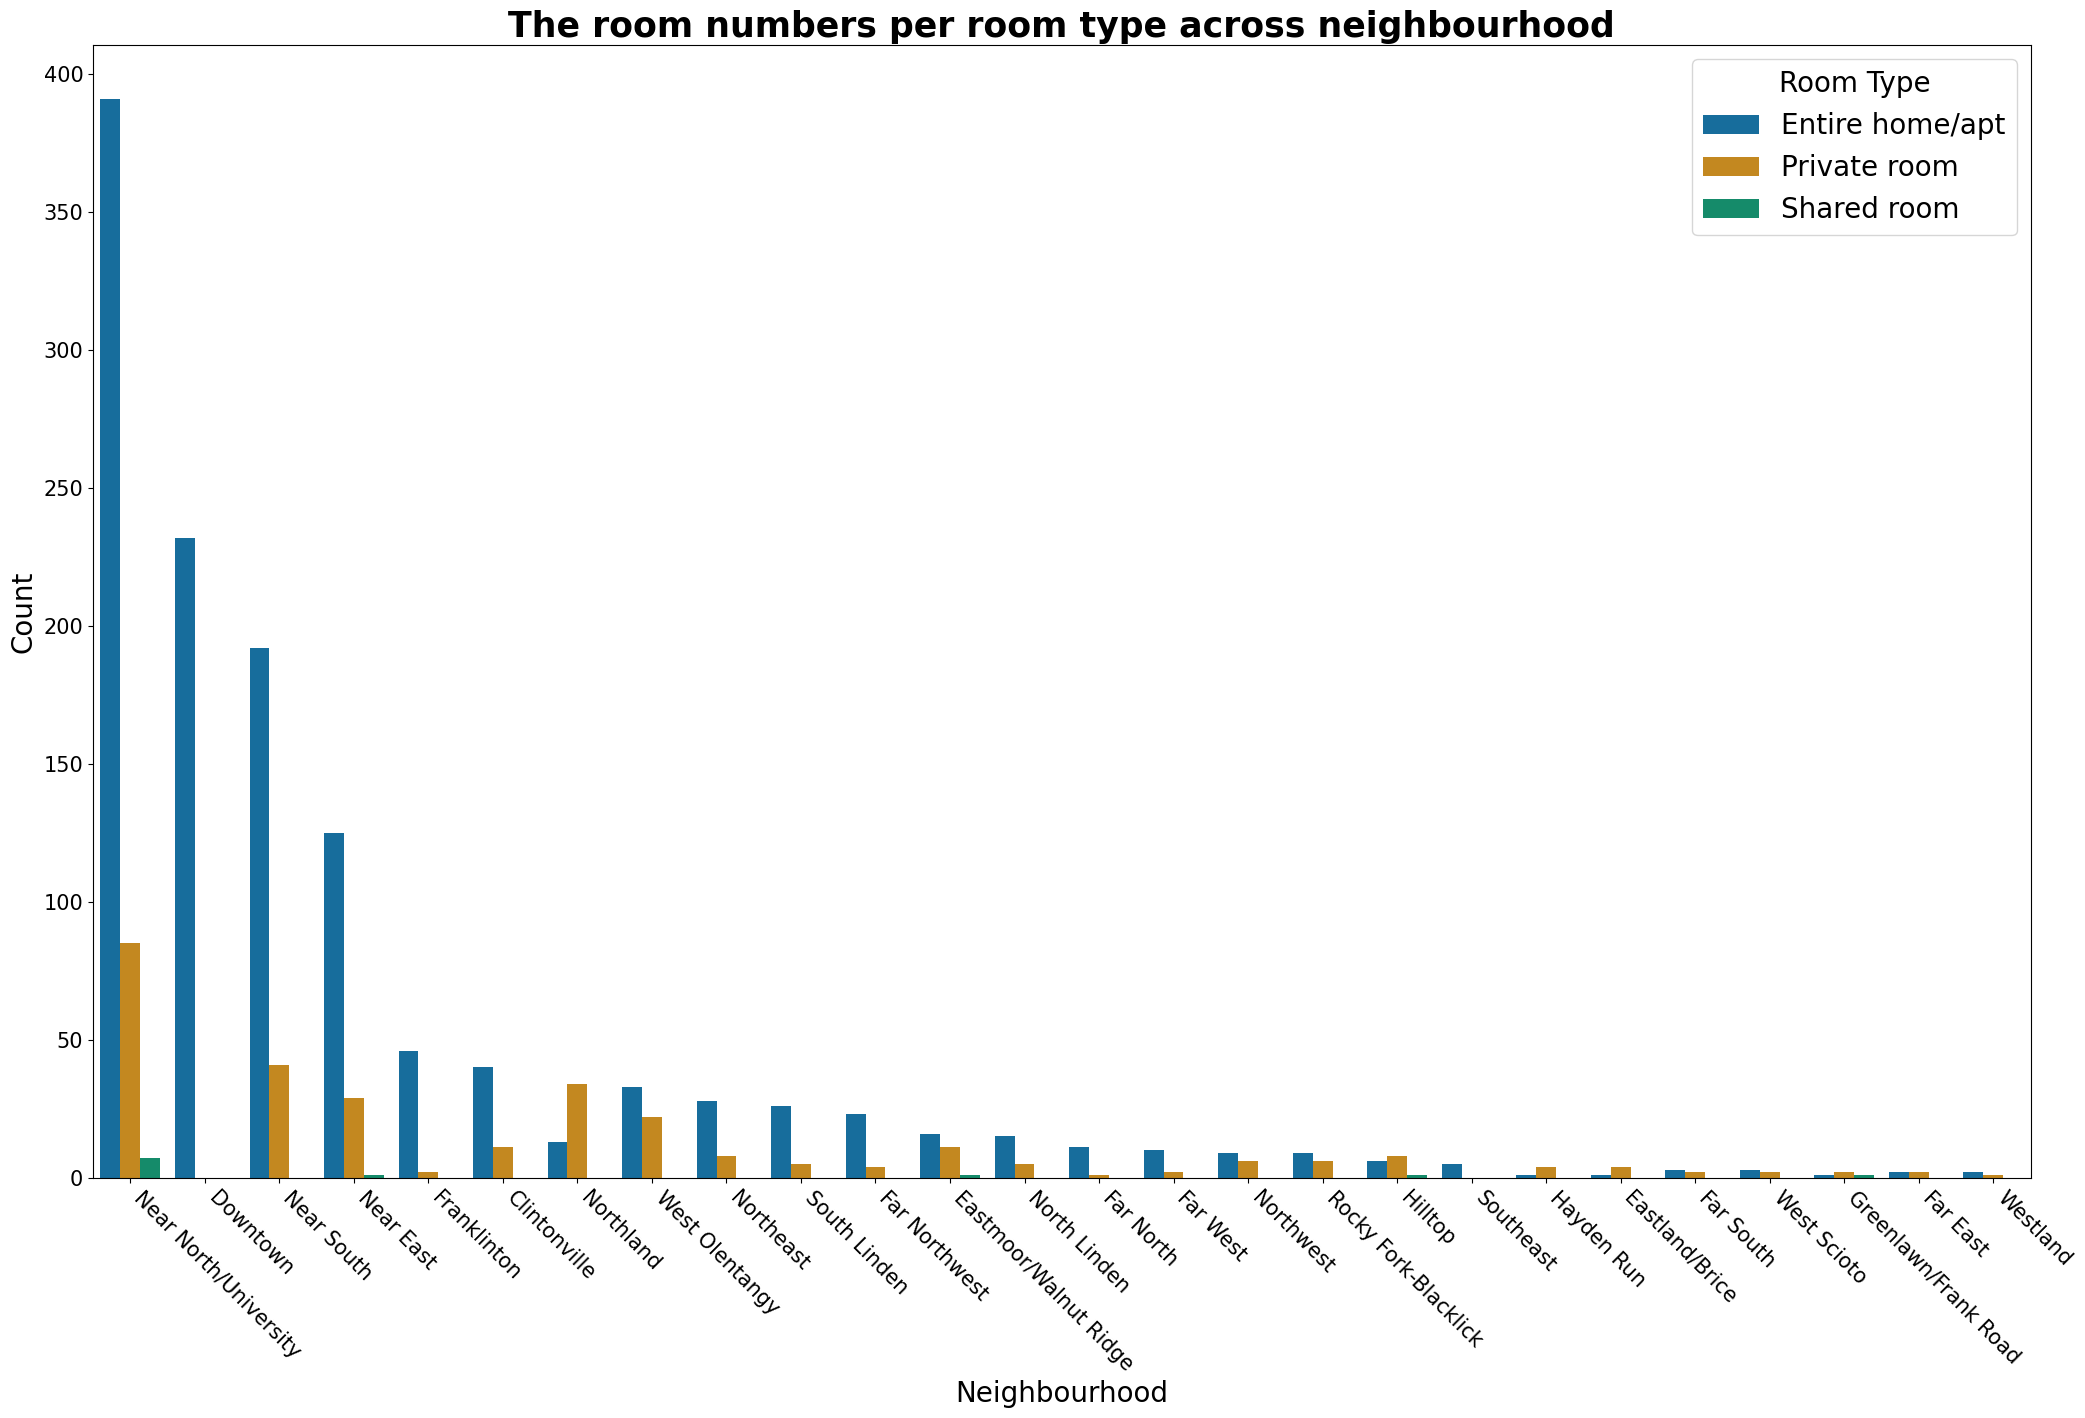

In [21]:
plt.figure(figsize=(25,15),dpi=100)
plt.title("The room numbers per room type across neighbourhood",size=25,fontweight='bold')

sns.barplot(x='neighbourhood',y='id',hue='room_type',data=count_room2, palette="colorblind")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
plt.tick_params(labelsize=15)
plt.ylabel('Count',fontdict={'size' :20})
plt.xlabel('Neighbourhood',fontdict={'size' :20})
plt.legend(title='Room Type',loc='upper right',fontsize=20,title_fontsize=20)
plt.show()

In [22]:
# Count numbers per room type per zipcode
count_zroom = listings_nooutlier.groupby(['zipcode','room_type'],as_index=False)['id'].count()
count_zroom1 = count_zroom.sort_values(by='id',axis=0,ascending=False)
count_zroom2 = pd.DataFrame(count_zroom1)
count_zroom2.head()

zipcode        room_type   id
17   43201  Entire home/apt  337
21   43203  Entire home/apt  275
28   43206  Entire home/apt  185
25   43205  Entire home/apt   73
35   43210     Private room   57

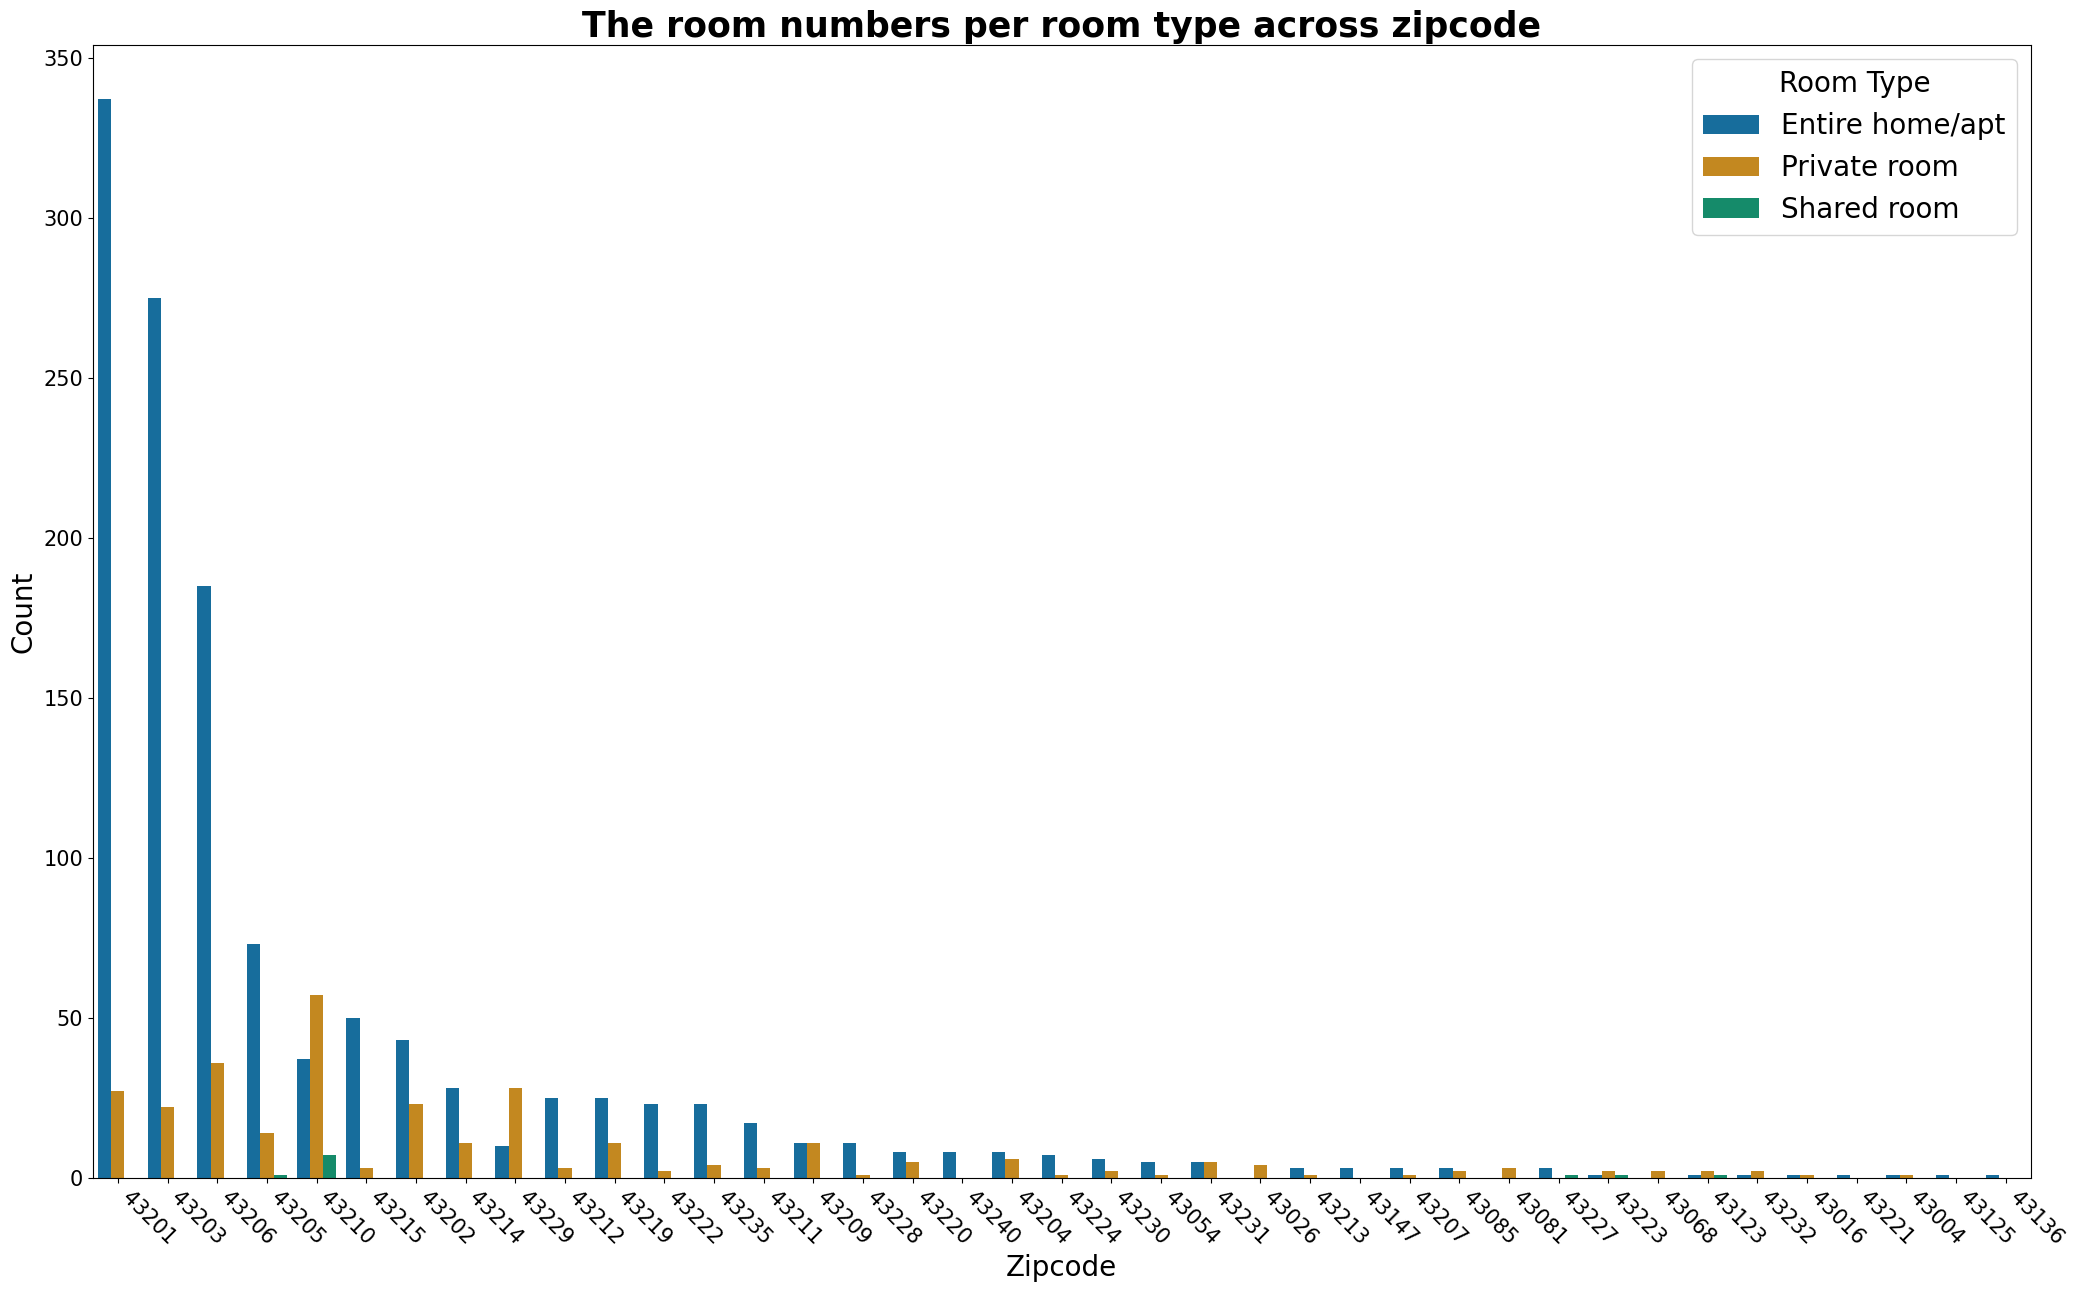

In [23]:
plt.figure(figsize=(25,15),dpi=100)
plt.title("The room numbers per room type across zipcode",size=25,fontweight='bold')

sns.barplot(x='zipcode',y='id',hue='room_type',data=count_zroom2, palette="colorblind")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
plt.tick_params(labelsize=15)
plt.ylabel('Count',fontdict={'size' :20})
plt.xlabel('Zipcode',fontdict={'size' :20})
plt.legend(title='Room Type',loc='upper right',fontsize=20,title_fontsize=20)
plt.show()

In [24]:
# Convert to datetime value
calendar["date"] = pd.to_datetime(calendar["date"])

# Sort the data by date
calendar = calendar.sort_values(by = "date")


rows_num = calendar.shape[0]

In [25]:
# Convert price into numerical type in calendar
calendar['price']=calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493115 entries, 0 to 493114
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      493115 non-null  int64         
 1   date            493115 non-null  datetime64[ns]
 2   available       493115 non-null  object        
 3   price           493115 non-null  float64       
 4   adjusted_price  493115 non-null  object        
 5   minimum_nights  493115 non-null  int64         
 6   maximum_nights  493115 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 30.1+ MB


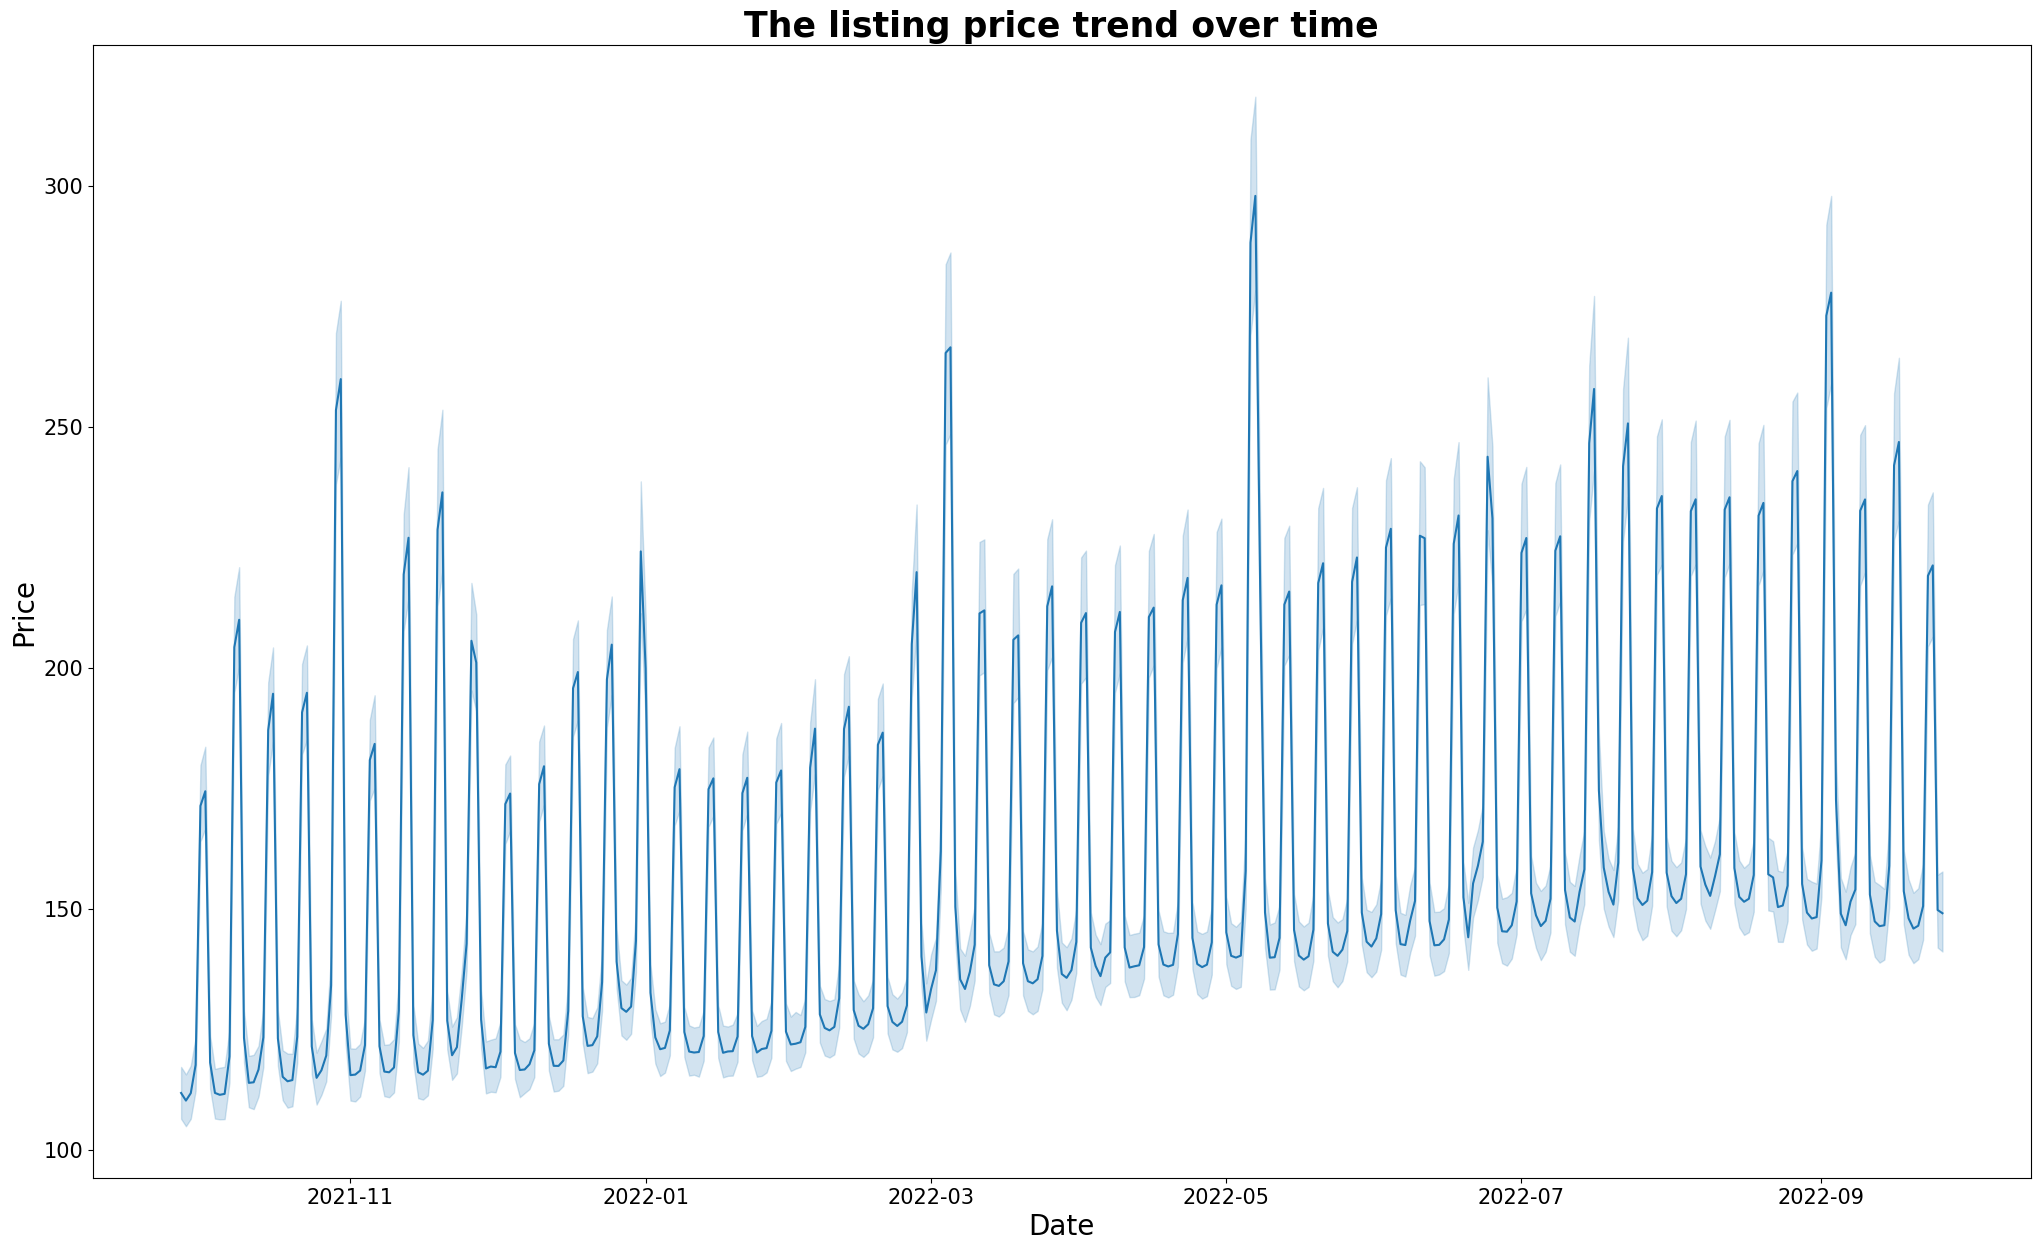

In [26]:
plt.figure(figsize=(25,15),dpi=100)
plt.title("The listing price trend over time",size=25,fontweight='bold')
sns.lineplot(x = 'date', y = 'price', data = calendar)
plt.tick_params(labelsize=15)
plt.ylabel('Price',fontdict={'size' :20})
plt.xlabel('Date',fontdict={'size' :20})
plt.show()

<ipython-input-27-420b9fd6911b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_nooutlier['zipcode'] = listings_nooutlier['zipcode'].astype(int)


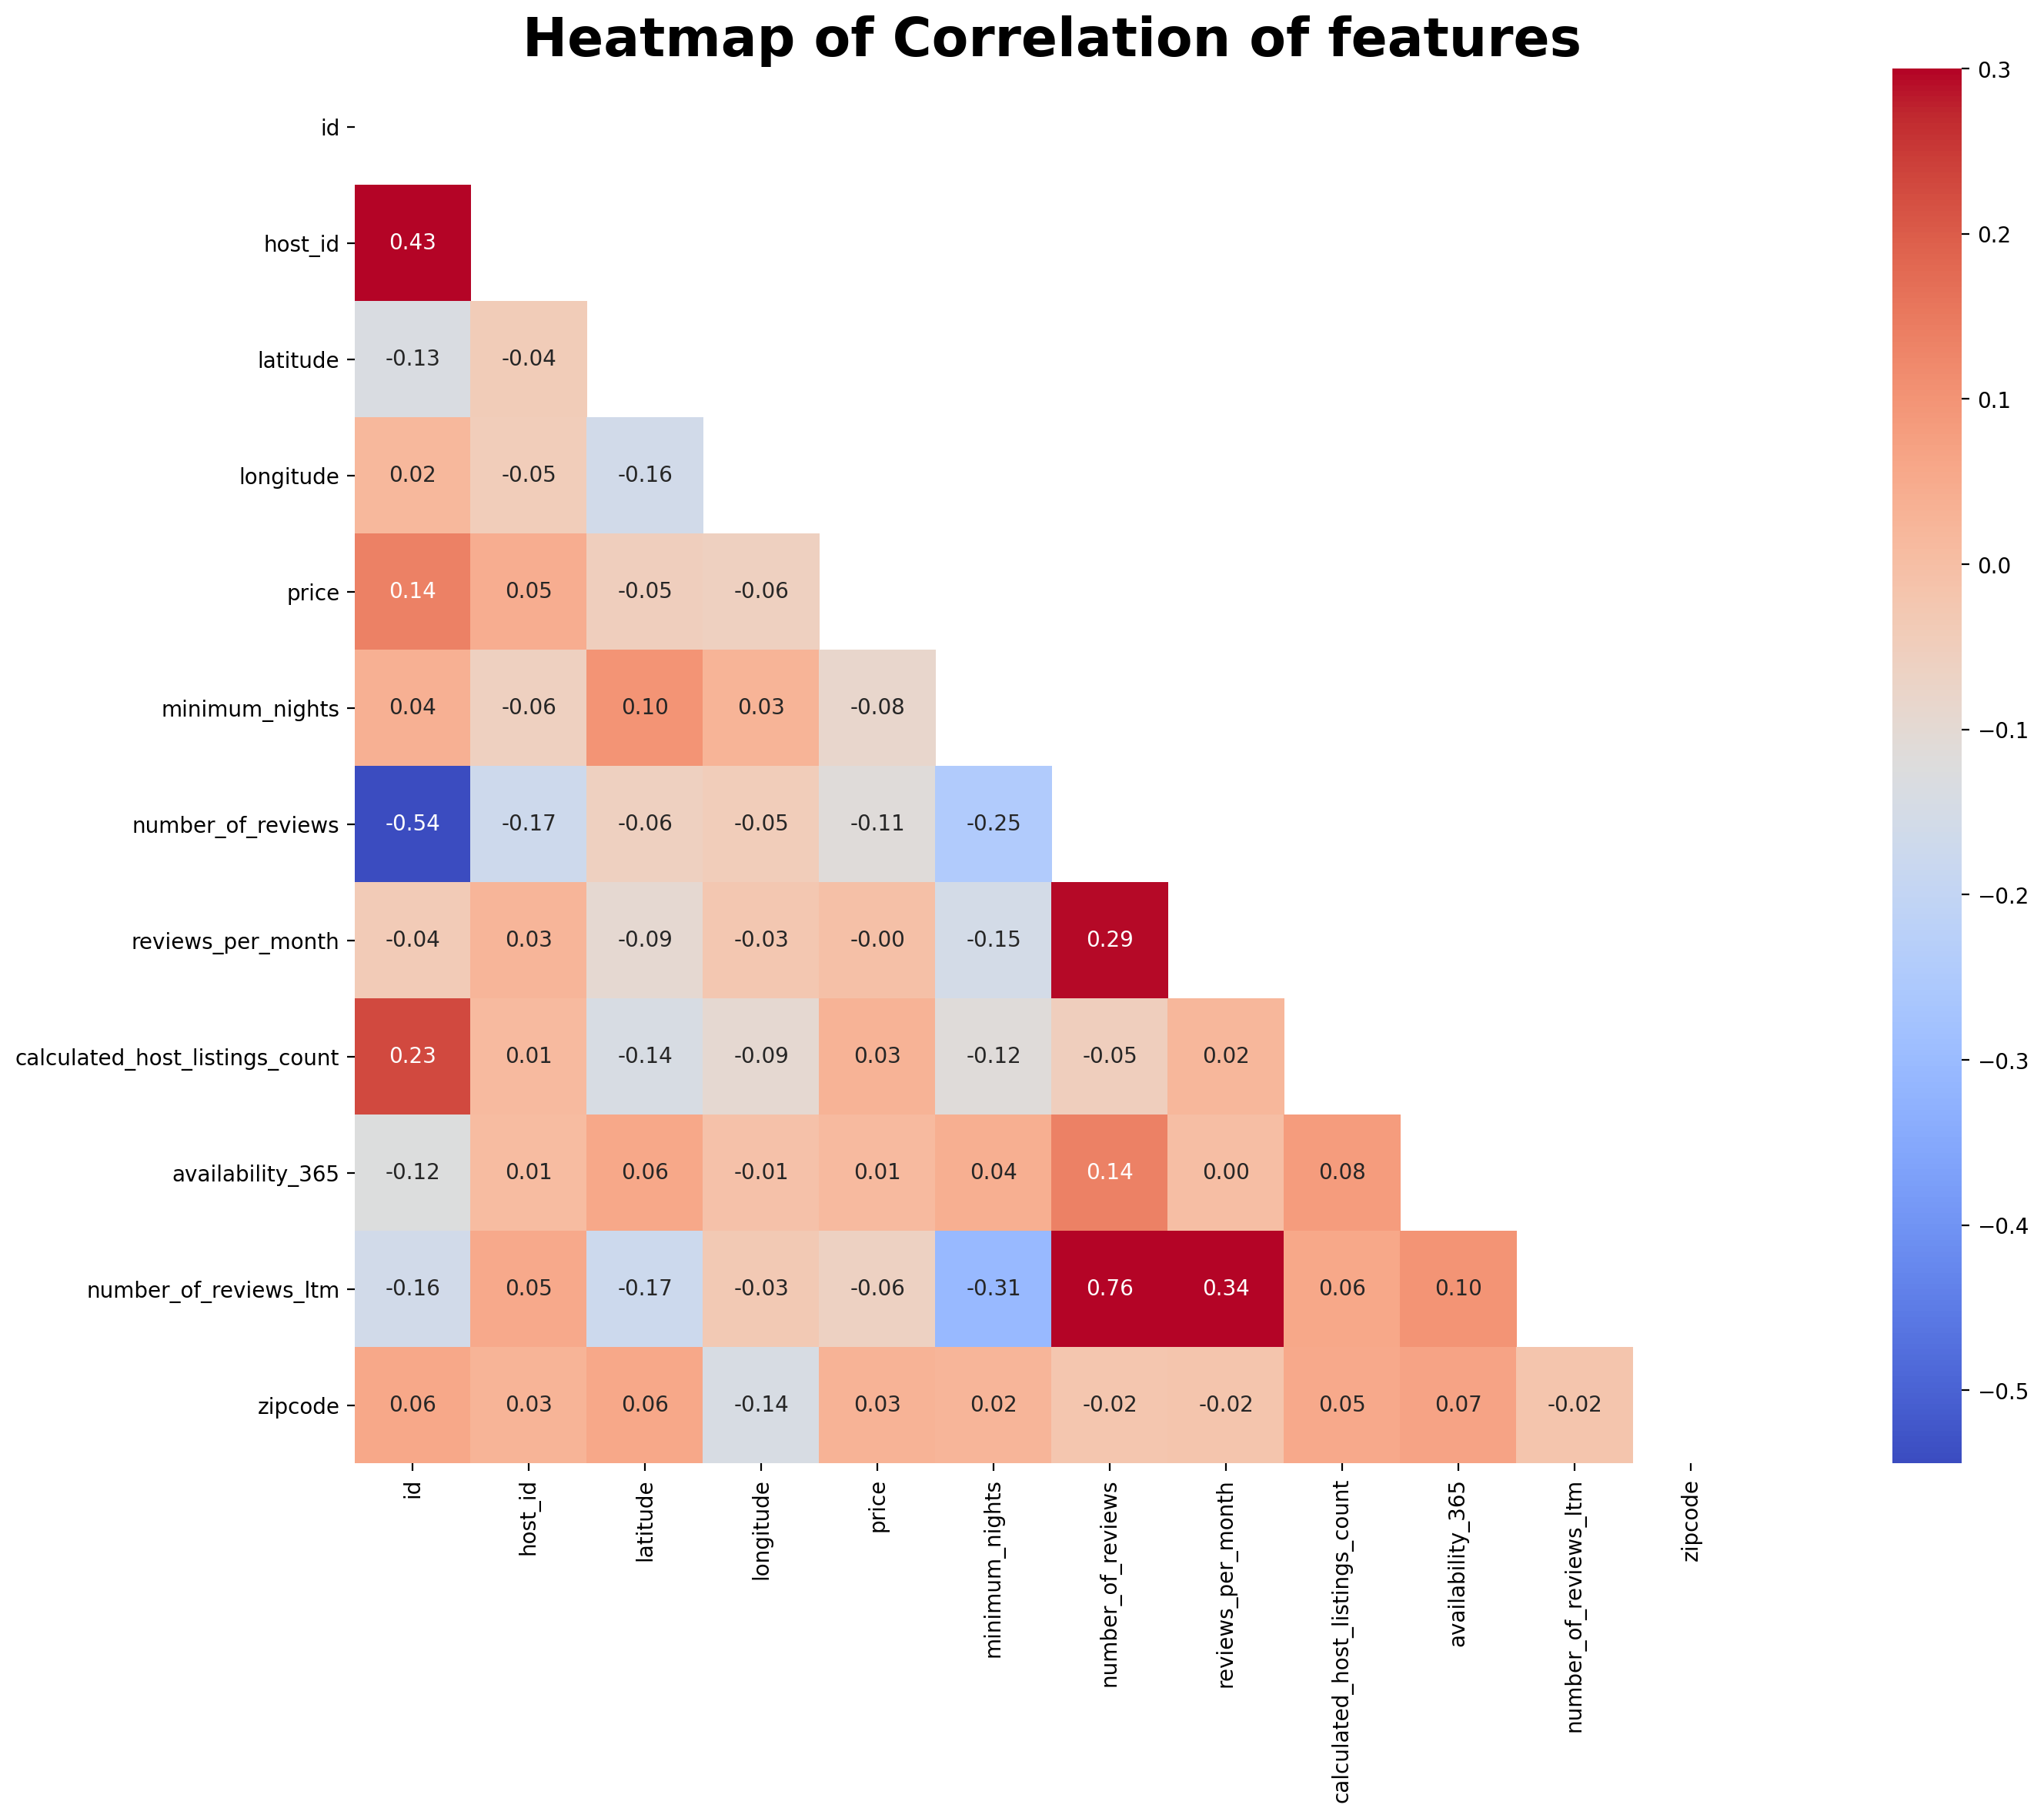

In [27]:
# Convert zipcode type to numeric
listings_nooutlier['zipcode'] = listings_nooutlier['zipcode'].astype(int)

# Drop useless column
listings_nooutlier = listings_nooutlier.drop(labels=['neighbourhood_group','license'], axis=1)


# 4.36 Correlation matrix
correlation = listings_nooutlier.select_dtypes(include=['int64', 'float64']).corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,12),dpi=200)
plt.title('Heatmap of Correlation of features',size=25,fontweight='bold')
sns.heatmap(correlation, mask = mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Statistical Model

In [28]:
# Prepare data 
listings_m = listings_nooutlier

In [29]:
# Convert categorical variables into numerical type
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
listings_m['neighbourhood'] = le.fit_transform(listings_m['neighbourhood'])
listings_m['room_type'] = le.fit_transform(listings_m['room_type'])
listings_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1551 entries, 0 to 1582
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1551 non-null   int64  
 1   name                            1551 non-null   object 
 2   host_id                         1551 non-null   int64  
 3   host_name                       1551 non-null   object 
 4   neighbourhood                   1551 non-null   int64  
 5   latitude                        1551 non-null   float64
 6   longitude                       1551 non-null   float64
 7   room_type                       1551 non-null   int64  
 8   price                           1551 non-null   int64  
 9   minimum_nights                  1551 non-null   int64  
 10  number_of_reviews               1551 non-null   int64  
 11  last_review                     1551 non-null   object 
 12  reviews_per_month               15

In [30]:
# Drop some features that are useless
listings_m1 = listings_m.drop(columns=['name','host_name','last_review'])
listings_m1.head()

id  host_id  neighbourhood  latitude  longitude  room_type  price  \
0   90676   483306             14  39.98394  -83.00321          0    135   
1  543140  2350409             14  40.01243  -83.00986          1     26   
2  591101  2889677             13  39.96086  -82.97968          1     80   
3  923248  4965048             14  40.01259  -83.00164          2     35   
4  923248  4965048             14  40.01259  -83.00164          2     35   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                496              30.24   
1               3                107               1.63   
2               2                242               5.84   
3               1                241               3.72   
4               1                241               3.72   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                               3               180                    101   
1                               3               333                      9   
2                               1               352                     20   
3                               7               365                     20   
4                               7               365                     20   

   zipcode  
0    43201  
1    43210  
2    43203  
3    43210  
4    43210

In [31]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    listings_m1.drop(labels=['price'], axis=1),
    listings_m1['price'],
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((1085, 13), (466, 13))

In [32]:
# instantiate the classifier with n_estimators = 100
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [33]:
# fit the classifier to the training set
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# predict on the test set
y_pred = clf.predict(X_test)

In [35]:
# predict on the test set
y_pred = clf.predict(X_test)

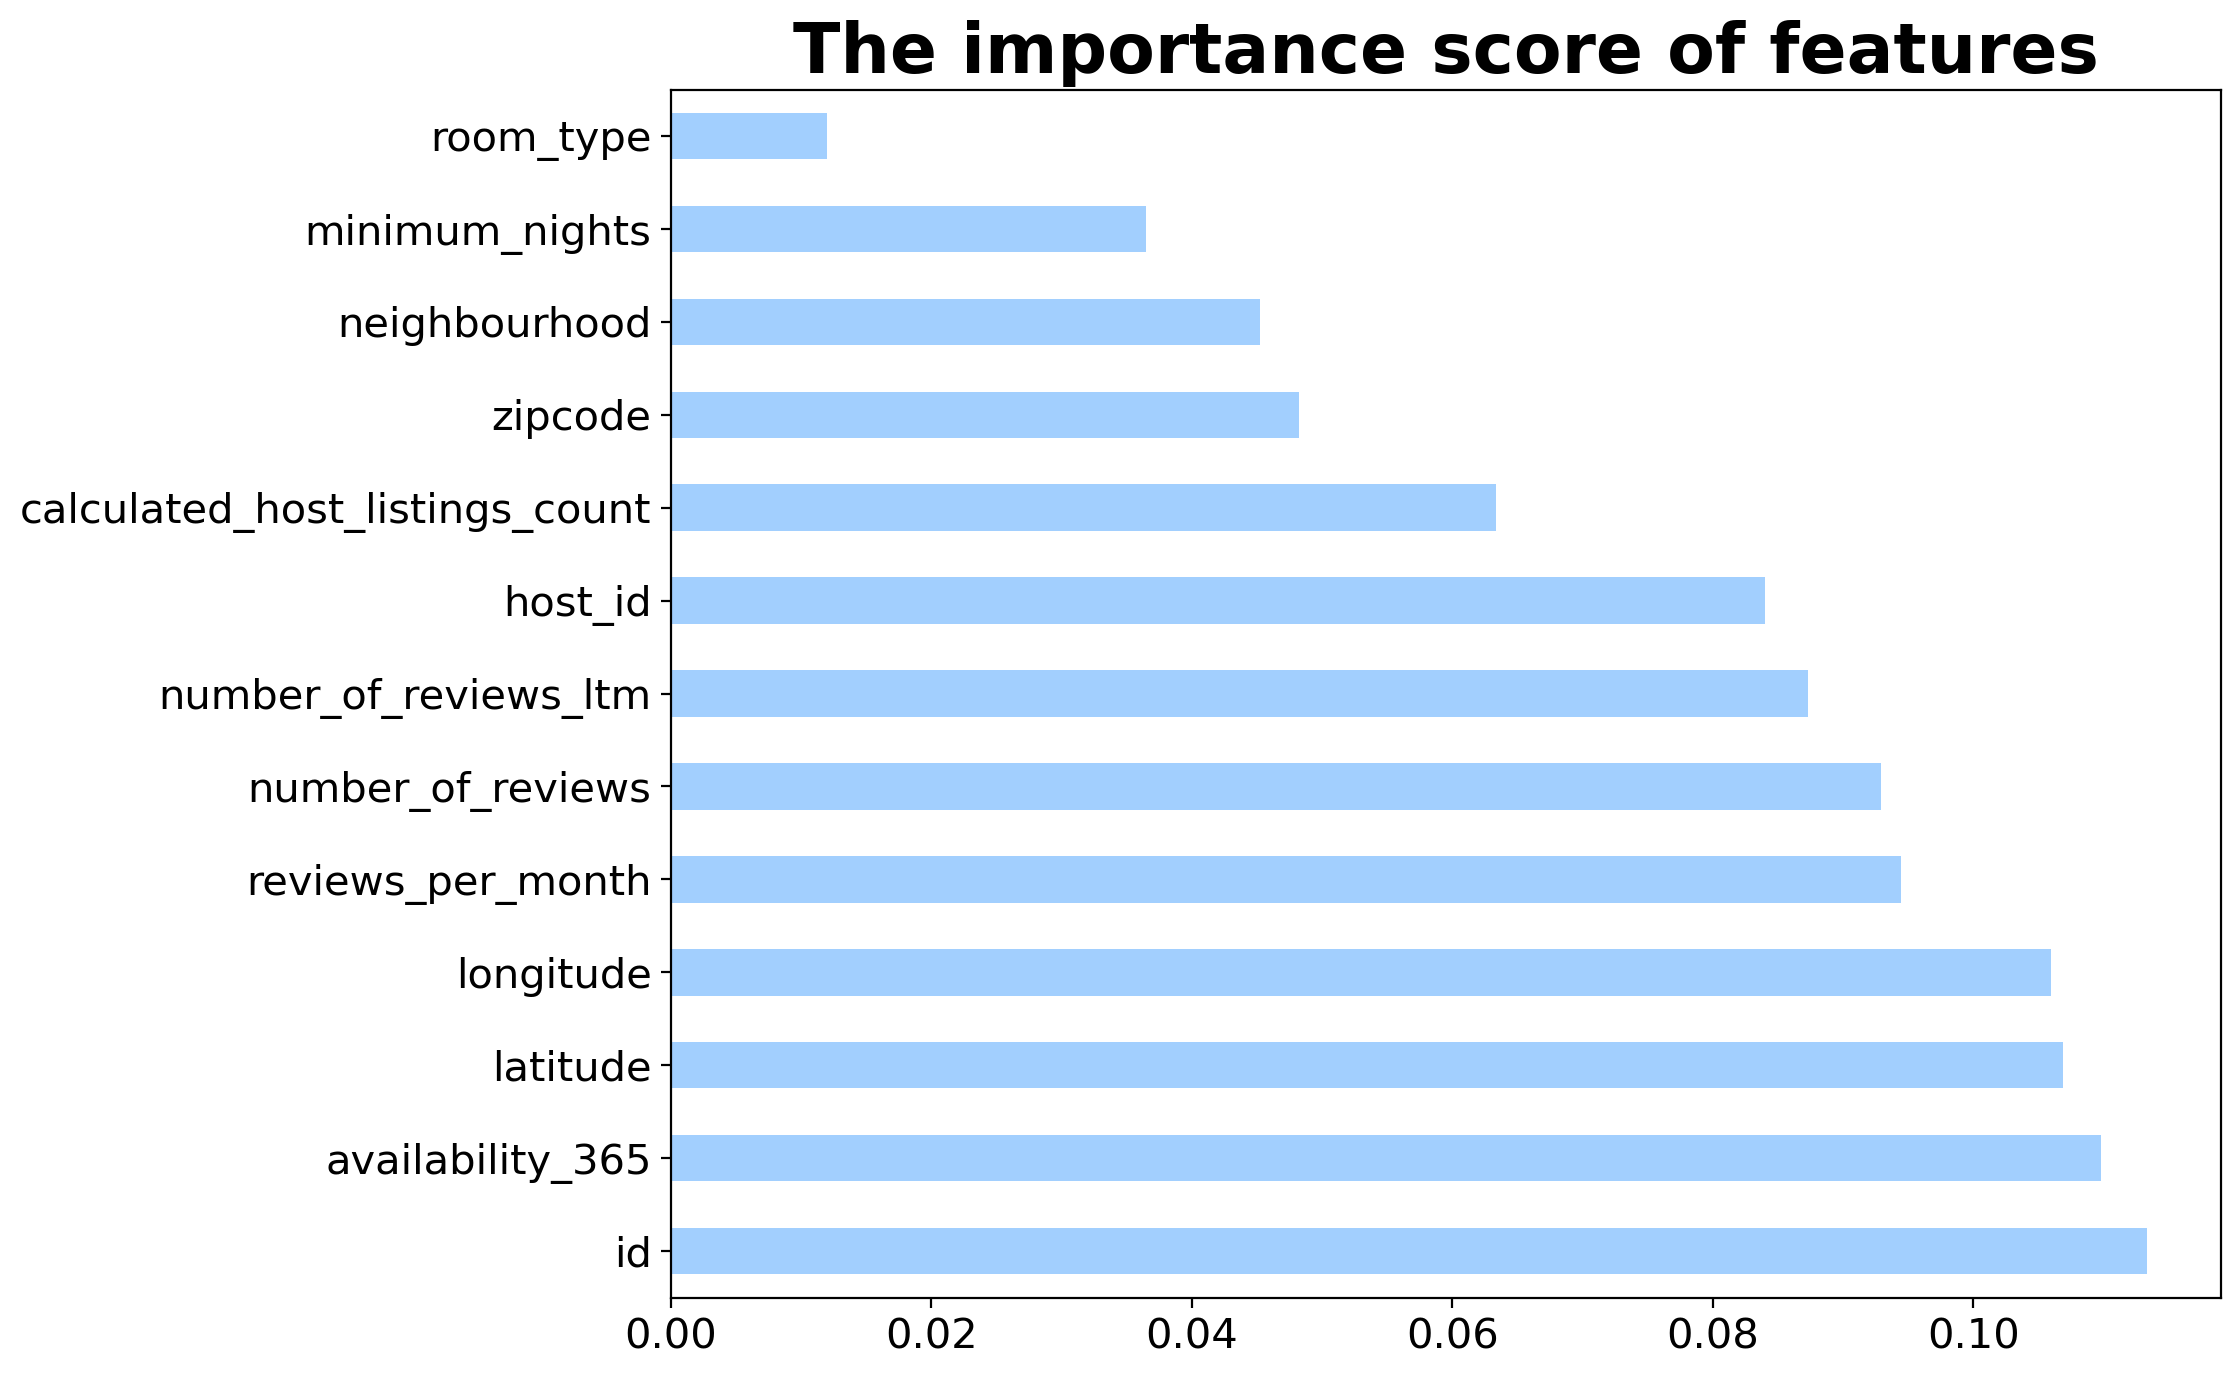

In [36]:
# visualize feature importance
plt.figure(num=None, figsize=(10,8), dpi=200, facecolor='w', edgecolor='k')
plt.title('The importance score of features',size=25,fontweight='bold')
feat_importances = pd.Series(clf.feature_importances_, index= listings_m1.drop(labels=['price'], axis=1).columns)
plt.tick_params(labelsize=15)
feat_importances.nlargest(15).plot(kind='barh',color={'xkcd:baby blue'})

In [37]:
# Create instance of Linear Regressor and evaluate the same
y1 = np.log2(y_train.astype(int))
y2 = np.log2(y_test.astype(int))
model_1 = LinearRegression()
m1 = model_1.fit(X_train,y1)
prediction1= m1.predict(X_test)

In [38]:
print('intercept:', m1.intercept_)
print('coefficients:', m1.coef_)

intercept: -132.83645838712945
coefficients: [-3.74770356e-09 -1.28524535e-10  3.69281055e-04  4.41104501e-02
 -1.09789271e+00 -1.07541179e+00 -1.23069068e-02 -1.41186811e-03
 -6.84417330e-04 -2.70852175e-03  4.98045909e-04 -6.53730910e-04
  1.09067095e-03]


In [39]:
#from sklearn.metrics import mean_absolute_error

def evaluate_model(y_test,prediction):
    test_set_rmse = (np.sqrt(mean_squared_error(y_test, prediction)))
    test_set_r2 = r2_score(y_test, prediction)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=200)
    axs[0].set_title('Distribution of predicted vs actual values',size=20,fontweight='bold')
    ax1 = sns.kdeplot(data=y_test, color="orange", label='Actual values', ax=axs[0])
    ax2 = sns.kdeplot(data=prediction, color="blue", label='Predicted values', ax=ax1)
    
    
    sns.regplot(x=y_test, y=prediction)
    plt.title('Distribution of predicted vs actual values',size=20,fontweight='bold')
    plt.xlabel('Actual Price',fontdict={'size' :10})
    plt.ylabel('Predicted Price',fontdict={'size' :10})
    plt.show()
    plt.close()
    
    print("The RMSE value of model is",test_set_rmse)
    print("The R square value of model is",test_set_r2)
    

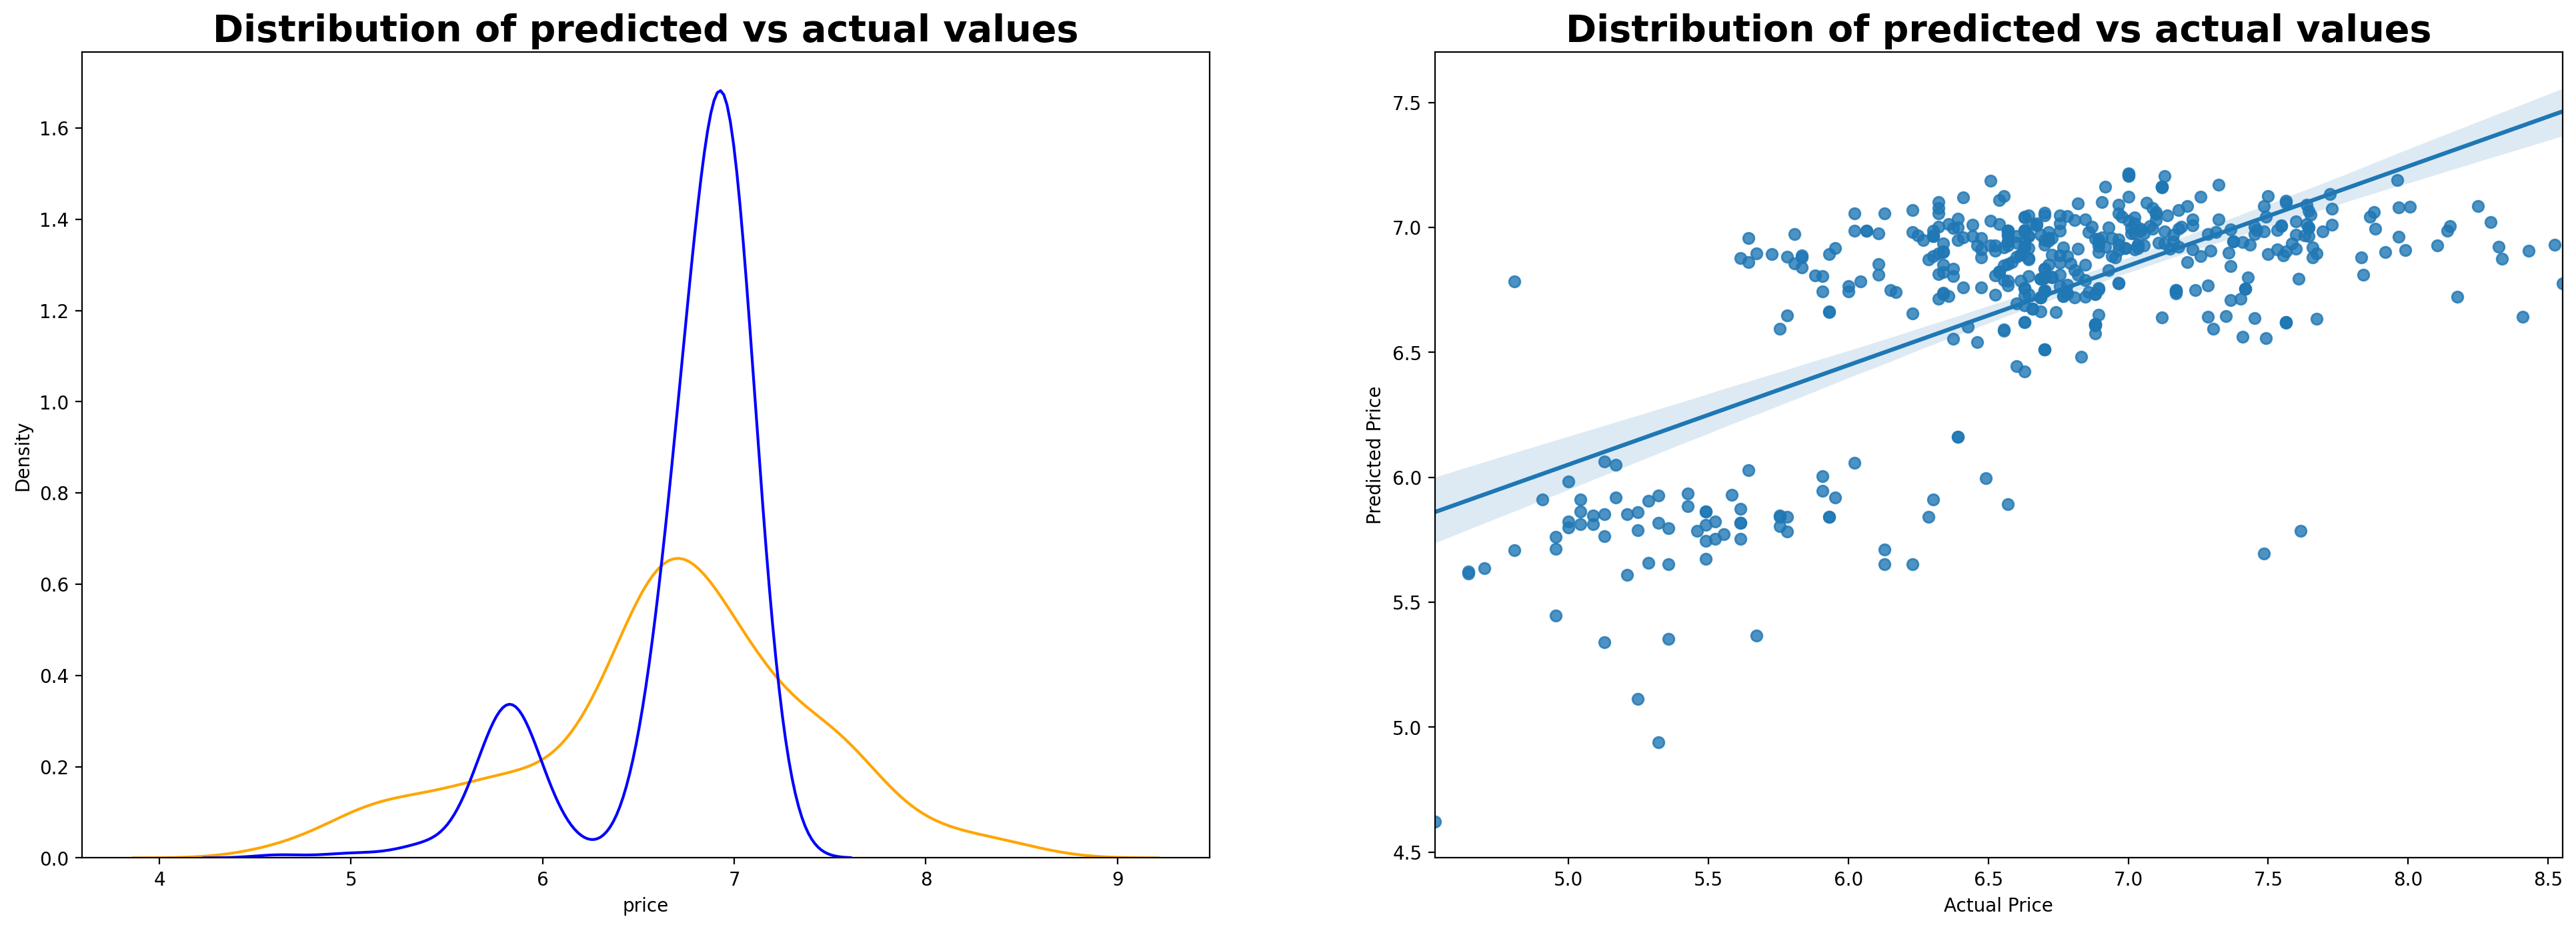

The RMSE value of model is 0.5633247904921181
The R square value of model is 0.4394093356284058


In [40]:
evaluate_model(y2,prediction1)

intercept: -132.83645838712945
coefficients: [-3.74770356e-09 -1.28524535e-10  3.69281055e-04  4.41104501e-02
 -1.09789271e+00 -1.07541179e+00 -1.23069068e-02 -1.41186811e-03
 -6.84417330e-04 -2.70852175e-03  4.98045909e-04 -6.53730910e-04
  1.09067095e-03]


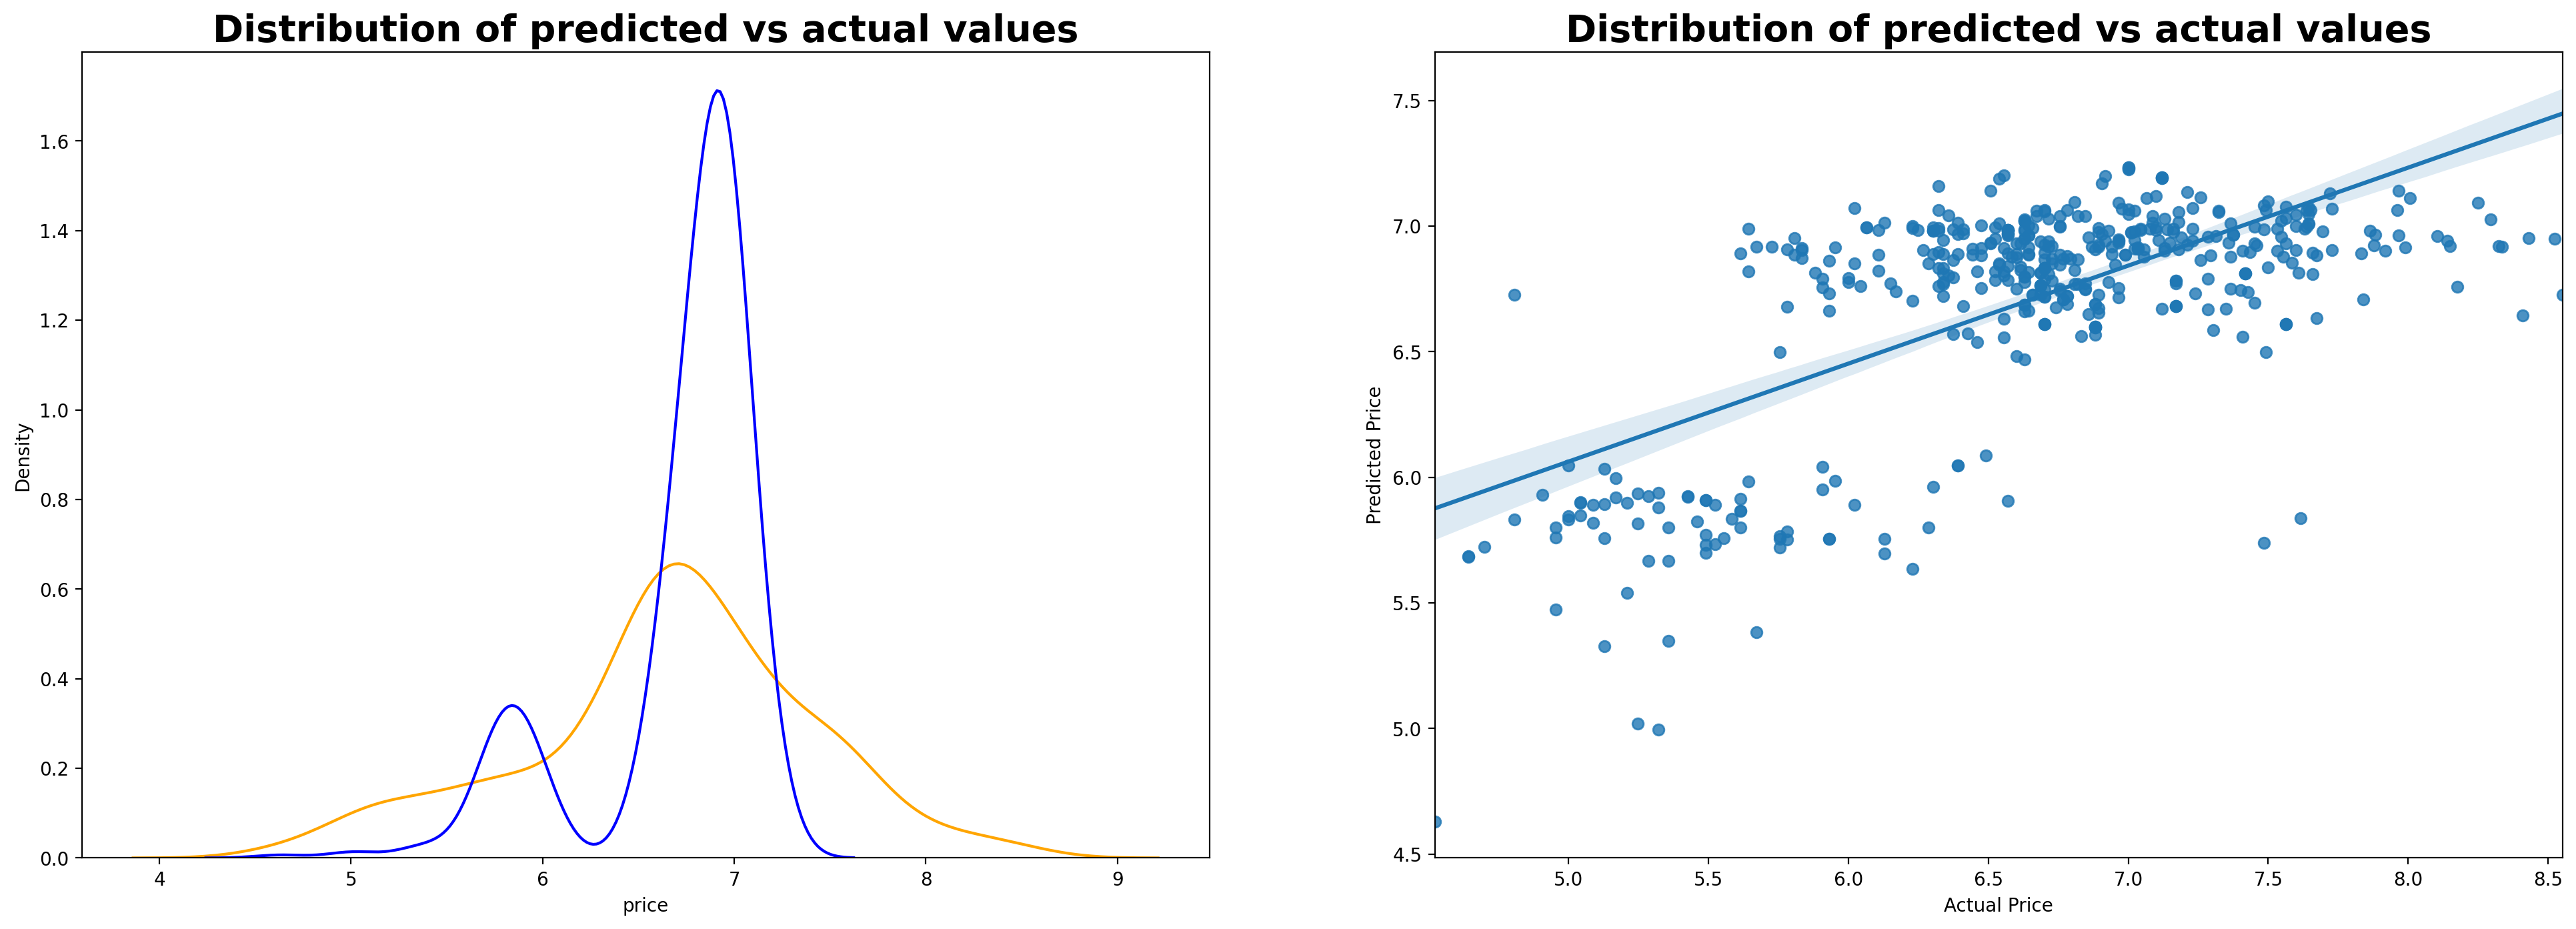

The RMSE value of model is 0.56765780199883
The R square value of model is 0.430752206483372


In [41]:
X_train1 = X_train.drop(labels=['id','host_id','number_of_reviews_ltm'], axis=1)
X_test1 = X_test.drop(labels=['id','host_id','number_of_reviews_ltm'], axis=1)

model_1 = LinearRegression()
m2 = model_1.fit(X_train1,y1)

print('intercept:', m1.intercept_)
print('coefficients:', m1.coef_)

prediction2 = m2.predict(X_test1)
evaluate_model(y2,prediction2)

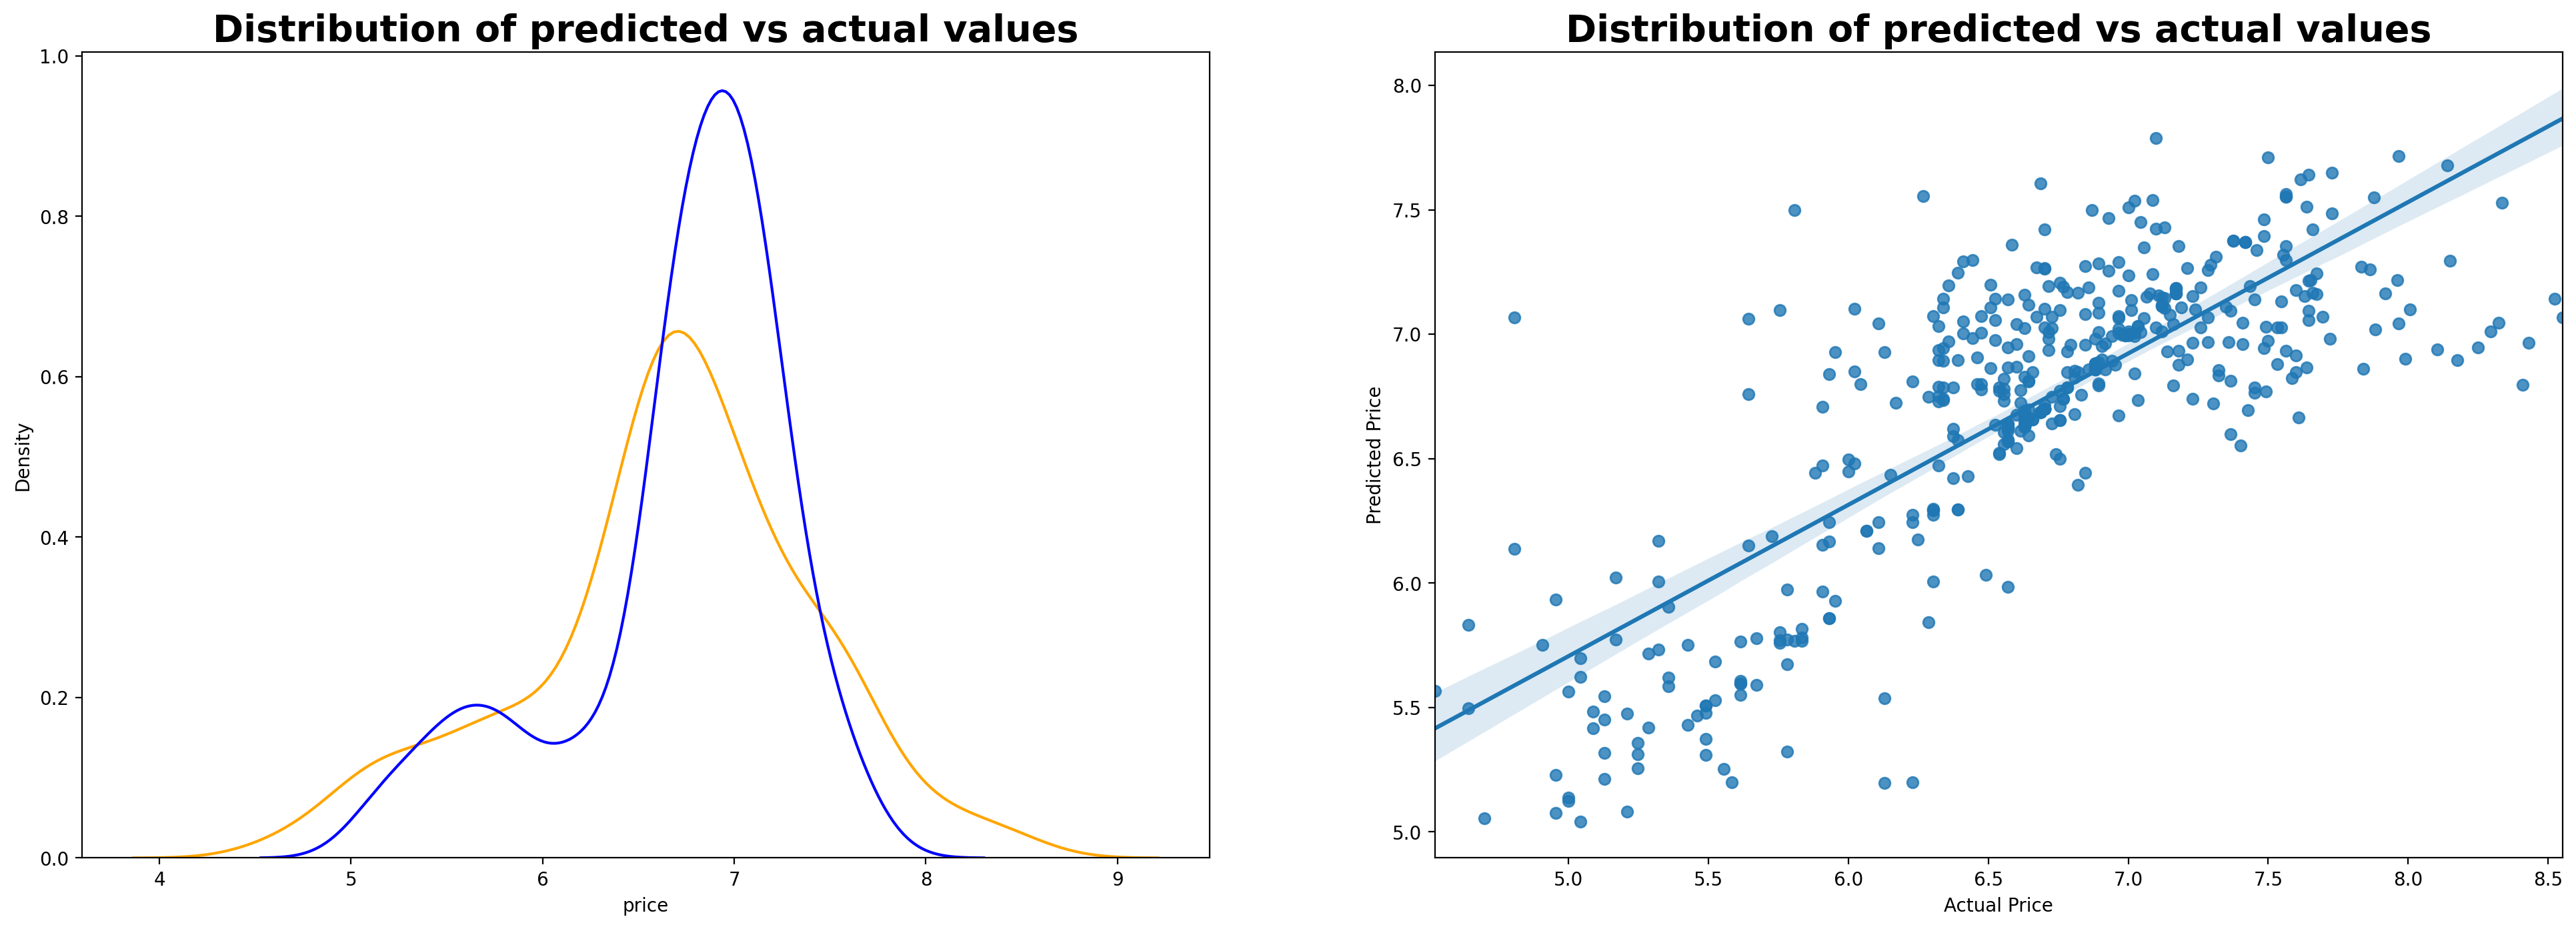

The RMSE value of model is 0.4713747101613864
The R square value of model is 0.6074809942222911


In [42]:
# Create instance of Random Forest Regressor and evaluate model
from sklearn.ensemble import RandomForestRegressor

model_2 = RandomForestRegressor(n_estimators=80, random_state=47)    
m3 = model_2.fit(X_train,y1)
prediction3 = m3.predict(X_test)
evaluate_model(y2,prediction3)

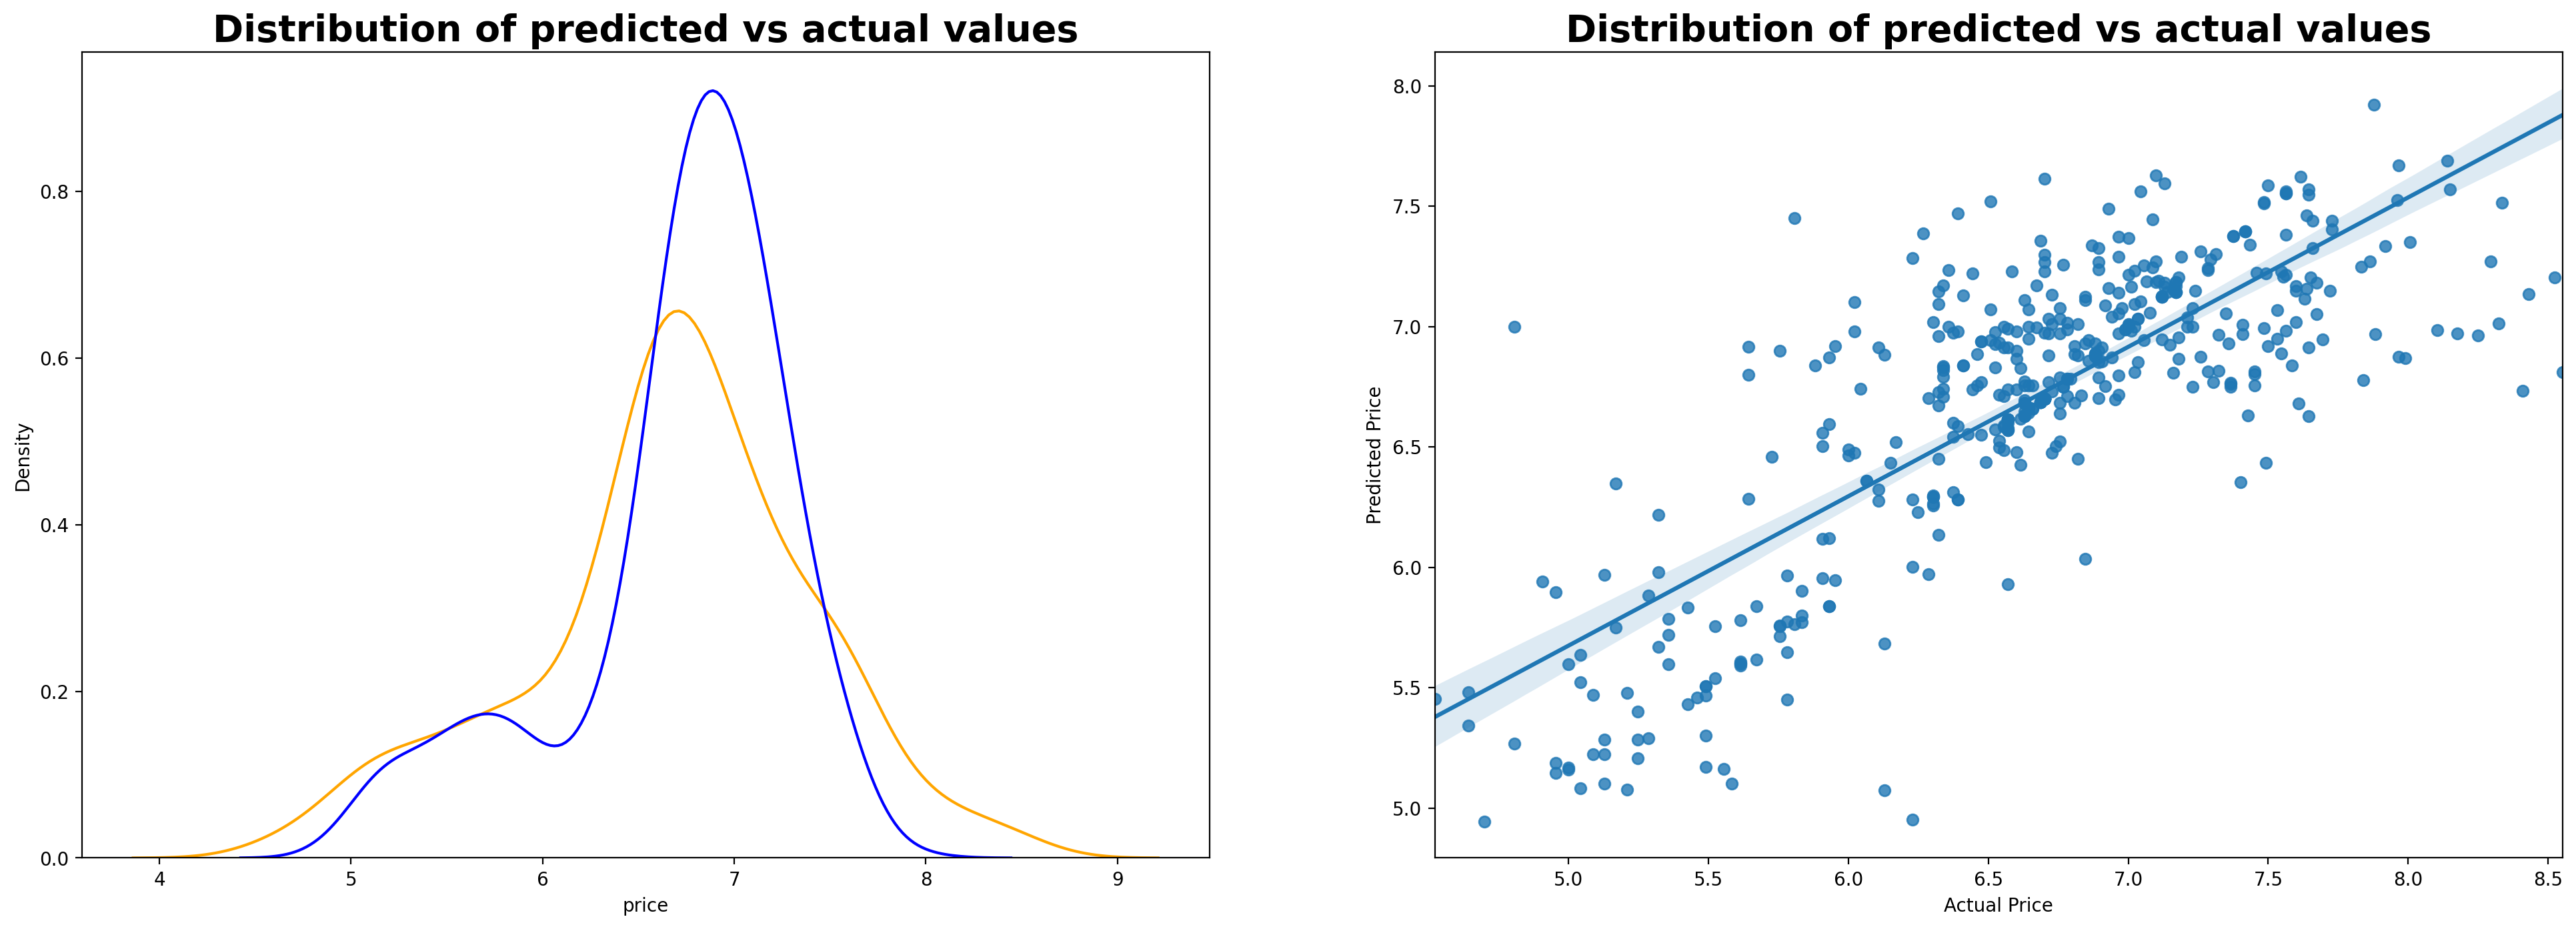

The RMSE value of model is 0.4665155766550379
The R square value of model is 0.6155317935776891


In [43]:
m4 = model_2.fit(X_train1,y1)
prediction4 = m4.predict(X_test1)
evaluate_model(y2,prediction4)